In [36]:
import pandas as pd
import os
import collections
import csv
import logging
import numpy as np
import datetime as datetime
import types
import pickle
from tqdm import tqdm
from scipy import spatial

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from top2vec import Top2Vec

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

pd.set_option('display.max_columns', 100)

In [2]:
!which jupyter

/home/ubuntu/thesis_env2/bin/jupyter


In [3]:
df = pd.read_pickle('./data/df_processed_bigrams.pickle')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 365200 entries, 0 to 369046
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   author             181507 non-null  object        
 1   date               365200 non-null  datetime64[ns]
 2   domain             365200 non-null  object        
 3   title              365115 non-null  object        
 4   url                365200 non-null  object        
 5   content            365200 non-null  object        
 6   topic_area         365200 non-null  object        
 7   content_processed  365200 non-null  object        
dtypes: datetime64[ns](1), object(7)
memory usage: 25.1+ MB


In [5]:
df.head(1).append(df.tail(1))

,author,date,domain,title,url,content,topic_area,content_processed
0,Thomas Hughes,2020-01-02,marketbeat,Three Industrial Giants You Should Own In 2020,https://www.marketbeat.com/originals/three-ind...,With the end of the year just around the corne...,business,end year corner past time think positioning fo...
369046,NaN,2020-12-31,marketscreener,FTSE 100 wraps up worst year since 2008 financ...,https://www.marketscreener.com/quote/index/FTS...,"The FTSE 100 lost 1.5%, with consumer stocks, ...",business,ftse lost consumer stocks mainly unilever diag...


In [6]:
# Note to do - need to add time element

def log_newline(self, how_many_lines=1):
    file_handler = None
    if self.handlers:
        file_handler = self.handlers[0]

    # Switch formatter, output a blank line
    file_handler.setFormatter(self.blank_formatter)
    for i in range(how_many_lines):
        self.info('')

    # Switch back
    file_handler.setFormatter(self.default_formatter)

def logger_w2v():
    
    log_file = os.path.join('./data', 'word2vec.log')
    print('log file location: ', log_file)
    
    log_format= '%(asctime)s - %(levelname)s - [%(module)s]\t%(message)s'
    formatter = logging.Formatter(fmt=(log_format))
    
    fhandler = logging.FileHandler(log_file)
    fhandler.setFormatter(formatter)
    
    logger = logging.getLogger('word2vec')
    logger.setLevel(logging.DEBUG)
    logger.addHandler(fhandler)
    logger.default_formatter = formatter
    logger.blank_formatter = logging.Formatter(fmt="")
    logger.newline = types.MethodType(log_newline, logger)
    
    return logger
    

In [7]:
def tokenise_dataset(df):

    tokens = df['content_processed'].str.split(" ")

    return tokens

# Top2Vec

In [8]:
find_topics = False
min_count = 1000 # ignore words with total frequency less than this
speed = 'deep-learn' # can try 'deep-learn' for possible better embeddings but will take longer
# started deep-lear at 8pm, still going at 2pm the next day

if find_topics:
    # import lemmatised data
    with open('data/data_lemmatized.pickle', 'rb') as f:
        data_lemmatized = pickle.load(f)
    
    data_lemmatized_str = [' '.join(article) for article in data_lemmatized]
    print(len(data_lemmatized))
    print(len(data_lemmatized_str))
    
    # Find topics
    # ~ 12.5 hours to run on lemmatised data
    #documents = df['content_processed'][:50000].values
    documents = data_lemmatized_str
    model = Top2Vec(documents, workers=4, min_count=min_count, speed=speed)
    model.save('top2vec_vocab_limit_deep.model')
else:
    #model = Top2Vec.load('top2vec.model')
    #model = Top2Vec.load('top2vec_vocab_limit.model')
    model = Top2Vec.load('top2vec_vocab_limit_deep.model')

print(len(model.topic_words))
print(model._get_word_vectors().shape)

1619
(9453, 300)


In [9]:
print(model.topic_words[0], '\n')
#print(model.topic_words[1], '\n')
#print(model.topic_words[2], '\n')

['presenter' 'itv' 'cohost' 'costar' 'susanna' 'schofield' 'strictly_come'
 'bbc_breakfast' 'steph' 'gmb' 'lorraine' 'garraway' 'pier' 'dancing'
 'strictly' 'contestant' 'viewer' 'lovely' 'carol' 'holly' 'dancer'
 'stacey' 'clarkson' 'bbc' 'eastender' 'reid' 'mum' 'follower' 'celebrity'
 'holme' 'weekday' 'morgan' 'laugh' 'dance' 'joke' 'pal' 'awkward' 'swipe'
 'reply' 'blunder' 'louise' 'loose' 'derek' 'comedian' 'hilary'
 'girlfriend' 'kay' 'fletcher' 'brilliant' 'emoji'] 



### Get topic sizes

Number of documents most similar to each topic. Topics are in decreasing order of size.  
topic_sizes: The number of documents most similar to each topic.  
topic_nums: The unique index of every topic will be returned.  

In [11]:
topic_sizes, topic_ids = model.get_topic_sizes()
df_topic_sizes = pd.DataFrame(data=zip(topic_ids, topic_sizes), columns=['topic_id', 'num_docs'])
print(df_topic_sizes['num_docs'].sum())
df_topic_sizes

365200


,topic_id,num_docs
0,0,3882
1,1,2972
2,2,2739
3,3,2512
4,4,2155
...,...,...
1768,1768,19
1769,1769,19
1770,1770,18
1771,1771,18


<AxesSubplot:>

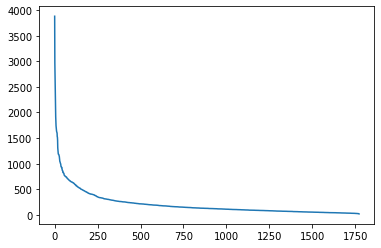

In [12]:
df_topic_sizes['num_docs'].plot()

### Get Topics
topic_words: For each topic the top 50 words are returned, in order of semantic similarity to topic.  
word_scores: For each topic the cosine similarity scores of the top 50 words to the topic are returned.  
topic_nums: The unique index of every topic will be returned.  

In [13]:
topic_words, word_scores, topic_ids = model.get_topics(model.get_num_topics())
topic_sizes, topic_ids = model.get_topic_sizes()
df_topics = pd.DataFrame(data=zip(topic_ids, topic_sizes, topic_words, word_scores), columns=['topic_id', 'topic_sizes', 'topic_words', 'word_scores'])

# add doc id's
df_topics['doc_ids'] = ''
for topic_idx, topic_size in enumerate(df_topics['topic_sizes']):
    documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=topic_idx, num_docs=topic_size)
    df_idx = df.iloc[document_ids].index.values
    df_topics['doc_ids'].at[topic_idx] = df_idx
print(df_topics['topic_sizes'].sum())

#df_topics.to_pickle("df_topics_top2vec_vocab_limit.pickle")

365200


In [14]:
df_topics

,topic_id,topic_sizes,topic_words,word_scores,doc_ids
0,0,3882,"[barrels_day, bpd, crude, opec, glut, oil, bar...","[0.7554733, 0.7397255, 0.7277012, 0.7076352, 0...","[48334, 48284, 294425, 159978, 20322, 292171, ..."
1,1,2972,"[touching_face, hands_clean, sick, rate_dippe,...","[0.31247112, 0.20629022, 0.20435627, 0.2030590...","[676, 30063, 20903, 18668, 21959, 21573, 3624,..."
2,2,2739,"[nongaap, gaap, ebitdare, divestiture, teekay,...","[0.26054233, 0.23778984, 0.22579505, 0.1927944...","[334982, 239075, 91056, 85241, 100487, 8321, 1..."
3,3,2512,"[vaccine, pfizer_biontech, pfizerbiontech, pfi...","[0.80440575, 0.7686322, 0.7623384, 0.7583906, ...","[236636, 225984, 225378, 225321, 347974, 22533..."
4,4,2155,"[hedge_fund, insider_monkey, hedgie, similarly...","[0.7718193, 0.57161814, 0.5356776, 0.51193756,...","[133035, 171698, 133512, 169086, 133335, 17170..."
...,...,...,...,...,...
1768,1768,19,"[safehaven, crude_future, greenback, japanese_...","[0.55273753, 0.49876994, 0.49868113, 0.4946041...","[183052, 183053, 182081, 181526, 181789, 18255..."
1769,1769,19,"[strategist, choppy, treasury_yield, selloff, ...","[0.44933143, 0.42233846, 0.41821185, 0.3859547...","[250960, 250028, 252600, 250770, 253406, 24993..."
1770,1770,18,"[gift, card, debit, wallet, credit_card, press...","[0.5080503, 0.49814865, 0.40992847, 0.384071, ...","[314138, 313298, 314772, 313117, 314512, 31364..."
1771,1771,18,"[dare, commercialize, nda, bioscience, investi...","[0.50853056, 0.4186489, 0.3713347, 0.3697553, ...","[158636, 159688, 154610, 155910, 316975, 31669..."


### Search for topics than contain keywords
topic_words: For each topic the top 50 words are returned, in order of semantic similarity to topic.  
word_scores: For each topic the cosine similarity scores of the top 50 words to the topic are returned.  
topic_scores: For each topic the cosine similarity to the search keywords will be returned.  
topic_nums: The unique index of every topic will be returned.  

In [15]:
keywords = ["supply_chain"]
#keywords = ["digital_transformation"]
topic_words, word_scores, topic_scores, topic_ids = model.search_topics(keywords=keywords, num_topics=5)
df_topic_kw = pd.DataFrame(data=zip(topic_ids, topic_words, word_scores, topic_scores), columns=['topic_id', 'topic_words', 'word_scores', 'topic_scores'])

In [16]:
df_topic_kw

,topic_id,topic_words,word_scores,topic_scores
0,859,"[generic, pharmaceutical, drug, novartis, phar...","[0.5529777, 0.41644132, 0.4071582, 0.37119797,...",0.332119
1,914,"[garment, bangladesh, boohoo, clothing, clothe...","[0.7322744, 0.50282276, 0.46981946, 0.46685526...",0.287537
2,93,"[tools_checklist, reinvent, transformation, ag...","[0.5508231, 0.49446157, 0.48091435, 0.477627, ...",0.252878
3,825,"[wto, multilateral, directorgeneral, bilateral...","[0.78679776, 0.5122057, 0.4868957, 0.46711993,...",0.246379
4,1132,"[respirator, fema, surgical_mask, protective_g...","[0.5727843, 0.45496583, 0.4493539, 0.43521297,...",0.242761


In [17]:
df_topic_kw['topic_words'][4]

array(['respirator', 'fema', 'surgical_mask', 'protective_gear',
       'general_motor', 'gown', 'invoke', 'face_shield', 'ventilator',
       'ppe', 'navarro', 'hhs', 'ford_motor', 'gm', 'goggle', 'azar',
       'lifesaving', 'procure', 'pentagon', 'shortage', 'reuse',
       'honeywell', 'fiat_chrysler', 'defense', 'manufacturer',
       'facemask', 'ford', 'automaker', 'esper', 'compel', 'supply_chain',
       'mask', 'supplier', 'task_force', 'cotton', 'stockpile', 'kushner',
       'scarce', 'lifesave', 'test_kit', 'supplychain', 'masks_glove',
       'redfield', 'prototype', 'operation_warp', 'covering', 'replenish',
       'administration', 'procurement', 'cloth'], dtype='<U15')

In [18]:
df_topic_kw['topic_words'][1]

array(['garment', 'bangladesh', 'boohoo', 'clothing', 'clothe', 'apparel',
       'textile', 'fashion', 'factory', 'cambodia', 'migrant_worker',
       'cotton', 'myanmar', 'bof', 'footwear', 'adida', 'designer',
       'gucci', 'levi', 'leather', 'burberry', 'exporter', 'supply_chain',
       'nepal', 'shoe', 'tshirt', 'retailer', 'minimum_wage', 'malaysian',
       'malaysia', 'gown', 'ngo', 'nike', 'exploitation', 'jc_penney',
       'casual', 'wage', 'jacket', 'vietnam', 'dress', 'fabric',
       'store_closure', 'informal', 'ethiopia', 'livelihood', 'worker',
       'precarious', 'remittance', 'leicester', 'shirt'], dtype='<U15')

### Search articles by topic

After finding the relevant topic number can then search by this  
documents: The documents in a list, the most similar are first.  
doc_scores: Semantic similarity of document to topic. The cosine similarity of the document and topic vector.  
doc_ids: Unique ids of documents. If ids were not given, the index of document in the original corpus.  

In [19]:
df_topics.head(3)#[300:330]

,topic_id,topic_sizes,topic_words,word_scores,doc_ids
0,0,3882,"[barrels_day, bpd, crude, opec, glut, oil, bar...","[0.7554733, 0.7397255, 0.7277012, 0.7076352, 0...","[48334, 48284, 294425, 159978, 20322, 292171, ..."
1,1,2972,"[touching_face, hands_clean, sick, rate_dippe,...","[0.31247112, 0.20629022, 0.20435627, 0.2030590...","[676, 30063, 20903, 18668, 21959, 21573, 3624,..."
2,2,2739,"[nongaap, gaap, ebitdare, divestiture, teekay,...","[0.26054233, 0.23778984, 0.22579505, 0.1927944...","[334982, 239075, 91056, 85241, 100487, 8321, 1..."


In [20]:
# Get all document scores - note: doc index is iloc
doc_id_score = []
for topic_num in df_topics['topic_id']:
    num_docs = df_topics[df_topics['topic_id'] == topic_num]['topic_sizes'].values[0]
    _, document_scores, document_ids = model.search_documents_by_topic(topic_num=topic_num, num_docs=num_docs)
    doc_id_score_temp = list(zip(document_ids, document_scores))
    doc_id_score = doc_id_score + doc_id_score_temp

print(len(doc_id_score))

365200


In [21]:
df_doc_id_score = pd.DataFrame(doc_id_score, columns=['doc_idx', 'doc_score']).sort_values(by='doc_idx')
df_doc_id_score = df_doc_id_score.set_index('doc_idx')
df_doc_id_score

,doc_score
doc_idx,
0,0.437342
1,0.383544
2,0.496218
3,0.750307
4,0.450103
...,...
365195,0.588367
365196,0.519550
365197,0.617454


In [22]:
topic_num = 1
num_docs = df_topics[df_topics['topic_id'] == topic_num]['topic_sizes'].values[0]
documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=topic_num, num_docs=num_docs)

result_df = df.iloc[document_ids]
result_df["document_scores"] = document_scores

result_df[:5]

# for index,row in result_df.iterrows():
#     print(f"Document: {index}, Score: {row.document_scores}")
#     print(f"Title: {row.title}")
#     print("-----------")
#     #print(row.content)
#     #print("-----------")

<ipython-input-22-08f4ce7add0a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df["document_scores"] = document_scores


,author,date,domain,title,url,content,topic_area,content_processed,document_scores
676,By The New York Times,2020-01-26,nytimes,"California Confirms Coronavirus Patient, Marki...",https://www.nytimes.com/2020/01/26/world/asia/...,The United States has confirmed a third case o...,business,united_states confirmed case novel coronavirus...,0.747889
30063,By Katie Rogers,2020-03-20,nytimes,"White House to Cancel In-Person Meeting of G7,...",https://www.nytimes.com/2020/03/19/us/politics...,WASHINGTON — The Group of 7 summit will not be...,business,washington group summit held scheduled camp da...,0.737186
20903,By Mike Isaac and Maggie Haberman,2020-03-14,nytimes,"Seeking Advice on the Coronavirus, Jared Kushn...",https://www.nytimes.com/2020/03/13/us/politics...,One night this week an urgent appeal went out ...,business,night week urgent appeal went facebook group e...,0.731532
18668,By Ann Carrns,2020-03-12,nytimes,Investors Nervous About Coronavirus Ask: Shoul...,https://www.nytimes.com/2020/03/12/business/co...,One personal finance question asked widely onl...,business,personal finance question asked widely online ...,0.730413
21959,By Benedict Carey,2020-03-16,nytimes,Coronavirus Is Hiding in Plain Sight,https://www.nytimes.com/2020/03/16/health/coro...,Scientists tracking the spread of the coronavi...,business,scientists tracking spread coronavirus reporte...,0.723550


### Search articles by Keywords

In [23]:
documents, document_scores, document_ids = model.search_documents_by_keywords(keywords=["supply_chain", "disrupt"], num_docs=2)
result_df = df.iloc[document_ids]
result_df["document_scores"] = document_scores

# for index,row in result_df.iterrows():
#     print(f"Document: {index}, Score: {row.document_scores}")
#     print(f"Title: {row.title}")
#     print("-----------")
#     print(row.content)
#     print("-----------")
#     print()

<ipython-input-23-fcfd46485b2e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df["document_scores"] = document_scores


### Find Similar Words / Get Word Vectors

In [10]:
# Get words in vocab
vocab_length = len(model._get_word_vectors())
print(vocab_length)

vocab = []
for n in range(vocab_length):
    vocab.append(model._index2word(n))

9453


In [11]:
[x for x in vocab if 'digital' in x]

['digital', 'digitally', 'digitalization']

In [16]:
model._get_word_vectors().shape

(9453, 300)

In [35]:
'\t'.join(str(x) for x in embeddings[0])

'-0.15497005\t0.11282266\t-0.05107929\t0.078497075\t0.069992565\t0.12696147\t0.026258862\t-0.035623923\t-0.10239399\t0.05173779\t0.0014650514\t0.008128483\t-0.03636372\t0.044215217\t0.10769952\t0.13580681\t0.037039317\t0.059636083\t-0.11281243\t-0.12349071\t-0.04773345\t0.070602\t-0.0040802318\t0.020271027\t0.06772374\t-0.11138417\t0.010470722\t0.020503884\t-0.06305103\t0.13700597\t-0.026061356\t0.11548152\t-0.023067495\t0.12815955\t-0.038648825\t-0.097700246\t0.011054105\t0.15172322\t0.040625483\t-0.029669605\t0.046203677\t0.10614704\t-0.0546699\t-0.040599983\t0.027294729\t-0.022406325\t-0.025861697\t-0.004213013\t0.022818692\t0.08193603\t-0.014622617\t-0.0102647655\t-0.06817897\t-0.023424508\t-0.0012330156\t0.08469505\t-0.0007449618\t0.093807474\t-0.0023858643\t-0.048837997\t0.16591036\t-0.050195247\t0.15352935\t0.0337096\t0.021693164\t-0.015214109\t-0.06873348\t-0.066828206\t-0.026220461\t-0.038435772\t-0.116999894\t-0.024577286\t-0.005734683\t-0.02835131\t0.06416969\t0.059391316\t-

In [36]:
# Export vectors and words

embeddings = model._get_word_vectors()
with open(os.path.join('data', 'embeddings_deep.tsv'), "w") as f:
    for vector in embeddings:
        vector_row = '\t'.join(str(x) for x in vector)
        f.write("{}\n".format(vector_row))


# Save Labels separately on a line-by-line manner.
with open(os.path.join('data', 'metadata_deep.tsv'), "w") as f:
    for subwords in vocab:
        f.write("{}\n".format(subwords))


In [196]:
print(f'vocabulary length: {len(model._get_word_vectors())}')

words_model, word_scores = model.similar_words(keywords=["blockchain"], num_words=20)
for word, score in zip(words_model, word_scores):
    print(f"{word} {score}")

vocabulary length: 9453
crypto 0.7339475896471704
cryptocurrency 0.7223465751571749
token 0.7094626918677862
bitcoin 0.6710637318804684
wallet 0.563877302620114
digital 0.5192096604585148
technology 0.49723881204269466
fintech 0.48585895800236173
mover 0.4684538275059805
ecosystem 0.4620795805226351
computing 0.46171321950439914
disruptive 0.46142414041928775
iot 0.4511787044711443
paypal 0.446341398142481
digitization 0.4420328973248886
ai 0.43636029229375606
authentication 0.43154503635004593
software 0.4264924680788341
enterprise 0.42178335012064716
startup 0.4184527057767875


In [27]:
#model._words2word_vectors(['supply'])
model._get_word_vectors() # word embeddings
model._index2word(1)

'company'

## Label Topics

In [28]:
df_topics_labelled = df_topics.copy()
df_topics_labelled['topic_label'] = ''

In [29]:
df_topics_labelled.head(1)

,topic_id,topic_sizes,topic_words,word_scores,doc_ids,topic_label
0,0,3882,"[barrels_day, bpd, crude, opec, glut, oil, bar...","[0.7554733, 0.7397255, 0.7277012, 0.7076352, 0...","[48334, 48284, 294425, 159978, 20322, 292171, ...",


In [30]:
#df_topics_labelled.loc[1457]['topic_label']

1700 - 1772 topic category label done

In [31]:
idx = 1772
topic_label = ['finance', 'company_specific', 'aurinia_pharmaceuticals']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1771
topic_label = ['finance', 'company_specific', 'dare_bioscience']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1770
topic_label = ['other', 'gift_cards']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1769
topic_label = ['finance', 'stock_market_rally']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1768
topic_label = ['finance', 'asian_shares']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1767
topic_label = ['finance', 'investor_letter_released']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1766
topic_label = ['entertainment', 'k_pop', 'bts', 'ipo']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1765
topic_label = ['finance', 'new_product_launches']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1764
topic_label = ['finance', 'company_specific', 'kodak']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1763
topic_label = ['finance', 'company_specific', 'blackbaud']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1762
topic_label = ['finance', 'us_stocks_down']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1761
topic_label = ['finance', 'company_specific', 'victory_square_technologies']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1760
topic_label = ['finance', 'computer_games']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1759
topic_label = ['covid', 'elon_musk', 'covid_19_positive']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1758
topic_label = ['other', 'mexico']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1757
topic_label = ['finance', 'general_industry_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1756
topic_label = ['finance', 'company_specific', 'co-diagnostics']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1755
topic_label = ['finance', 'company_specific', 'costco']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1754
topic_label = ['other', 'delhi_court']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1753
topic_label = ['finance', 'france', 'stimulus']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1752
topic_label = ['finance', 'company_specific', 'samsung', 'leader_in_court']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1751
topic_label = ['finance', 'us_stocks_up']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1750
topic_label = ['finance', 'company_specific', 'tomi_environmental_solutions', 'disinfectant']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1749
topic_label = ['finance', 'company_specific', 'baudax_bio']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1748
topic_label = ['finance', 'company_specific', 'gran_colombia']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1747
topic_label = ['finance', 'company_specific', 'aytu_bioScience']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1746
topic_label = ['finance', 'us_stocks_up']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1745
topic_label = ['entertainment', 'celebrities', 'rich']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1744
topic_label = ['covid', 'china', 'swine_flu']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1743
topic_label = ['finance', 'company_specific', 'liminal_biosciences']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1742
topic_label = ['finance', 'company_specific', 'microsoft', 'closing_retail_stores']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1741
topic_label = ['finance', 'company_specific', 'mesoblast_limited']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1740
topic_label = ['politics', 'sri_lanka', 'elections']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1739
topic_label = ['covid', 'bryan_cranston', 'covid_19_positive']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1738
topic_label = ['finance', 'general_industry_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1737
topic_label = ['politics', 'south_korea', 'elections']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1736
topic_label = ['finance', 'company_specific', 'Halo']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1735
topic_label = ['sport', 'dwayne_johnson', 'football']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1734
topic_label = ['finance', 'medical_trials']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1733
topic_label = ['finance', 'general_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1732
topic_label = ['finance', 'investor_letter_released']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1731
topic_label = ['finance', 'company_specific', 'qiagen']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1730
topic_label = ['finance', 'company_specific', 'rollins']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1729
topic_label = ['finance', 'general_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1728
topic_label = ['sport', 'football', 'newcastle']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1727
topic_label = ['finance', 'general_industry_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1726
topic_label = ['finance', 'dividend_notices']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1725
topic_label = ['ignore', 'foreign_language']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1724
topic_label = ['finance', 'company_specific', 'tonix_pharmaceuticals']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1723
topic_label = ['finance', 'company_specific', 'tesla', 'curevac']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1722
topic_label = ['finance', 'company_specific', 'mateon_therapeutics']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1721
topic_label = ['finance', 'company_specific', 'sernova']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1720
topic_label = ['finance', 'company_specific', 'jde_peet', 'coffee']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1719
topic_label = ['finance', 'general_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1718
topic_label = ['covid', 'santa_barbara']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1717
topic_label = ['ignore', 'foreign_language']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1716
topic_label = ['finance', 'general_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1715
topic_label = ['finance', 'gamesbeat_summit']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1714
topic_label = ['finance', 'general_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1713
topic_label = ['finance', 'company_specific', 'akoustis']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1712
topic_label = ['finance', 'company_specific', 'pandora']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1711
topic_label = ['covid']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1710
topic_label = ['finance', 'covid', 'company_specific', 'synairgen', 'stocks_soar', 'effective_drug']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1709
topic_label = ['sport', 'nascar']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1708
topic_label = ['finance', 'general_trust_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1707
topic_label = ['finance', 'us_stocks_down']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1706
topic_label = ['finance', 'stocks_up', 'eu_recovery_fund']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1705
topic_label = ['finance', 'ethanol_companies']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1704
topic_label = ['finance', 'company_specific', 'corning_incorporated']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1703
topic_label = ['finance', 'company_specific', 'gtx', 'supercom']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1702
topic_label = ['other', 'italy', 'genoa_new_bridge']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1701
topic_label = ['covid', 'india', 'drug_approval', 'itolizumab']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1700
topic_label = ['finance', 'company_specific', 'amazon', 'new_product_launches', 'home_services']
df_topics_labelled.at[idx, 'topic_label'] = topic_label

1600 - 1699 topic category label done

In [101]:
#topic category label done
idx = 1699
topic_label = ['other', 'south_korea', 'mayor_dead']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1698
topic_label = ['finance', 'canada', 'healthcare_companies', 'company_takeovers']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1697
topic_label = ['finance', 'general_industry_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1696
topic_label = ['finance', 'covid', 'pharmaceutical_companies', 'disinfectants_approved']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1695
topic_label = ['ignore', 'foreign_language']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1694
topic_label = ['finance', 'coffee_companies', 'financial_irregularities']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1693
topic_label = ['finance', 'general_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1692
topic_label = ['finance', 'us_shares_down']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1691
topic_label = ['finance', 'company_specific', 'immunomedics']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1690
topic_label = ['finance', 'us_shares_up', 'vaccine_hopes']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1689
topic_label = ['finance', 'company_specific', 'catalyst_biosciences']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1688
topic_label = ['finance', 'company_specific', 'sinovac_biotech']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1687
topic_label = ['finance', 'company_specific', 'easyjet', 'director_disagreements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1686
topic_label = ['finance', 'covid', 'company_specific', 'eli_lilly', 'treatments']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1685
topic_label = ['finance', 'company_specific', 'twitter', 'half_year_update']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1684
topic_label = ['finance', 'general_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1683
topic_label = ['finance', 'general_industry_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1682
topic_label = ['finance', 'us_shares_up', 'vaccine_hopes']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1681
topic_label = ['covid', 'outbreak', 'maine']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1680
topic_label = ['finance', 'company_specific', 'twitter', 'ceo']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1679
topic_label = ['covid', 'human_seismic_action_reduced',]
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1678
topic_label = ['finance', 'company_specific', 'amc', 'bondholder_deal']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1677
topic_label = ['finance', 'company_specific', 'amgen']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1676
topic_label = ['finance', 'company_specific', 'ncl_corporation']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1675
topic_label = ['covid', 'china', 'kazakhstan', 'pneumonia']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1674
topic_label = ['finance', 'company_specific', 'redhill_biopharma']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1673
topic_label = ['finance', 'china', 'tech_companies', 'american_depositary_shares_offering']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1672
topic_label = ['finance', 'company_specific', 'valneva']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1671
topic_label = ['finance', 'general_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1670
topic_label = ['finance', 'company_specific', 'lufthansa', 'government_bailout']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1669
topic_label = ['finance', 'company_specific', 'citigroup', 'revlon', 'mistaken_payment']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1668
topic_label = ['finance', 'company_specific', 'era_group', 'nokia']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1667
topic_label = ['other', 'melania_trump', 'white_house_rose_garden']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1666
topic_label = ['finance', 'general_stock_updates', 'gold_up',]
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1665
topic_label = ['finance', 'company_specific', 'tata_consultancy_services',]
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1664
topic_label = ['finance', 'company_specific', 'warner_music', 'ipo']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1663
topic_label = ['finance', 'company_specific', 'centogene']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1662
topic_label = ['finance', 'company_specific', 'pfizer', 'biontech', 'vaccine_documents_hacked']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1661
topic_label = ['finance', 'company_specific', 'wwe']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1660
topic_label = ['finance', 'company_specific', 'amd', 'nvidia', 'microprocessor']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1659
topic_label = ['covid', 'global_tech_show_ces', 'online_only']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1658
topic_label = ['politics', 'kanye_west', 'presidential_bid']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1657
topic_label = ['finance', 'credit_cards', 'digital_payments']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1656
topic_label = ['finance', 'company_specific', 'air_asia', 'trading_halt', 'auditor_concerns']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1655
topic_label = ['sport', 'football_womens']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1654
topic_label = ['finance', 'general_stock_updates',]
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1653
topic_label = ['finance', 'company_specific', 'smt_scharf']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1652
topic_label = ['finance', 'ukraine', 'central_bank']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1651
topic_label = ['covid', 'italy', 'prime_minister', 'covid_positive']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1650
topic_label = ['covid', 'australia', 'journalists_evacuated_from_china']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1649
topic_label = ['covid', 'japan', 'economic_concerns']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1648
topic_label = ['finance', 'company_specific', 'majesco']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1647
topic_label = ['finance', 'company_specific', 'lg_chem', 'chemical_leak']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1646
topic_label = ['covid', 'sharon_stone', 'sister_fighting_for_life']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1645
topic_label = ['covid', 'who', 'us_withdrawal']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1644
topic_label = ['politics', 'general_britain_france_german_relations']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1643
topic_label = ['finance', 'us_retail', 'employee_bonus', 'employee_wage_increase']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1642
topic_label = ['finance', 'pharamceutical_companies', 'drug_trial_submissions']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1641
topic_label = ['finance', 'company_specific', 'marathon_gold']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1640
topic_label = ['finance', 'royalty_companies', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1639
topic_label = ['finance', 'company_specific', 'churchill_downs_incorporated']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1638
topic_label = ['politics', 'uganda', 'bobi_wine', 'new_political_party']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1637
topic_label = ['finance', 'company_specific', 'regeneron_pharmaceuticals']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1636
topic_label = ['finance', 'company_specific', 'alliance_data']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1635
topic_label = ['covid', 'early_concerns_growing']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1634
topic_label = ['other', 'canada', 'nova_scotia', 'mass_shooting']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1633
topic_label = ['finance', 'company_specific', 'hydro_one']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1632
topic_label = ['finance', 'covid', 'canadian_pharmaceutical_companies', 'organ_failure_drugs', 'covid_treatment']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1631
topic_label = ['other', 'ruth_baber_ginsburg', 'cancer']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1630
topic_label = ['covid', 'white_house_covid_exposure']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1629
topic_label = ['covid', 'white_house_covid_exposure']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1628
topic_label = ['finance', 'company_specific', 'shell']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1627
topic_label = ['sport', 'football', 'efl']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1626
topic_label = ['covid', 'india', 'kasmir', 'restrictions_politically_motivated']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1625
topic_label = ['finance', 'company_specific', 'tauriga_sciences']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1624
topic_label = ['finance', 'company_specific', 'airbnb', 'house_parties_banned']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1623
topic_label = ['finance', 'company_specific', 't_mobile']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1622
topic_label = ['finance', 'company_specific', 'happiness_biotech']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1621
topic_label = ['finance', 'us_shares_down']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1620
topic_label = ['politics', 'alexandria_ocasio-cortez']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1619
topic_label = ['finance', 'company_specific', 'accenture']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1618
topic_label = ['finance', 'cpi_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1617
topic_label = ['finance', 'company_specific', 'ascendis_pharma']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1616
topic_label = ['covid', 'holiday_spread_warnings']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1615
topic_label = ['finance', 'company_specific', 'chf_Solutions']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1614
topic_label = ['covid', 'us_cares_act_funding']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1613
topic_label = ['finance', 'company_specific', 'Gilead_Sciences', 'covid_19', 'remdesivir_reduced_deaths']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1612
topic_label = ['other', 'uk_royalty']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1611
topic_label = ['finance', 'company_specific', 'Dynavax']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1610
topic_label = ['finance', 'auto_companies', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1609
topic_label = ['ignore', 'foreign_language']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1608
topic_label = ['covid', 'vaccine_development']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1607
topic_label = ['finance', 'company_specific', 'Alpha_Bank']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1606
topic_label = ['finance', 'company_specific', 'GM', 'legal_fight_fiat_chrysler']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1605
topic_label = ['finance', 'company_specific', 'Universal_Display_Corporation']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1604
topic_label = ['finance', 'general_stock_updates',]
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1603
topic_label = ['ignore', 'foreign_language']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1602
topic_label = ['covid', 'hackers_targeting_vaccine_developers']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1601
topic_label = ['politics', 'australia', 'ex_prime_minister_appointed_trade_minister']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1600
topic_label = ['entertainment', 'music', 'oasis']
df_topics_labelled.at[idx, 'topic_label'] = topic_label

1500 - 1599 topic category label done

In [102]:
# topic category label done
idx = 1599
topic_label = ['finance', 'us_shares_down']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1598
topic_label = ['finance', 'company_specific', 'everbridge', 'critical_event_management']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1597
topic_label = ['finance', 'company_specific', 'hsbc', 'job_cuts']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1596
topic_label = ['finance', 'diagnostic_tests']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1595
topic_label = ['finance', 'job_cuts']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1594
topic_label = ['finance', 'company_specific', 'unilever', 'company_unification']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1593
topic_label = ['other', 'legal', 'ghislaine_maxwell']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1592
topic_label = ['entertainment', 'jeopardy']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1591
topic_label = ['finance', 'short_selling_bans']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1590
topic_label = ['technology', 'company_specific', 'zoom', 'security']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1589
topic_label = ['finance', 'general_industry_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1588
topic_label = ['finance', 'company_specific', 'canadian_pacific_railway']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1587
topic_label = ['other', 'company_specific', 'royal_mail_uk']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1586
topic_label = ['other', 'michigan', 'flooding']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1585
topic_label = ['finance', 'australia', 'general_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1584
topic_label = ['finance', 'company_specific', 'unilever', 'consumer_goods_sales']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1583
topic_label = ['finance', 'company_specific', 'sanofi']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1582
topic_label = ['finance', 'general_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1581
topic_label = ['covid', 'trump', 'covid_downplayed']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1580
topic_label = ['finance', 'covid', 'company_specific', 'johnson_and_johnson', 'covid_vaccine_development']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1579
topic_label = ['finance', 'covid', 'company_specific', 'mesoblast', 'covid_vaccine_development']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1578
topic_label = ['covid', 'dogs_covid_detection']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1577
topic_label = ['covid', 'new_york', 'case_numbers']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1576
topic_label = ['covid', 'florida', 'case_numbers']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1575
topic_label = ['finance', 'forex_movements', 'yen', 'us_dollar']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1574
topic_label = ['finance', 'covid', 'company_specific', 'kronos_advanced_technologies', 'covid_filters']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1573
topic_label = ['finance', 'covid', 'company_specific', 'emerson_electric']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1572
topic_label = ['politics', 'eu', 'ireland', 'trade_portfolio_lost']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1571
topic_label = ['finance', 'covid', 'disinfection_product_sales']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1570
topic_label = ['finance', 'covid', 'thermal_cameras']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1569
topic_label = ['finance', 'covid', 'company_specific', 'astrazeneca', 'alexion', 'takeover']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1568
topic_label = ['finance', 'covid', 'nyse', 'trading_floor_reopening']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1567
topic_label = ['finance', 'covid', 'company_specific', 'cisco', 'stock_price_movements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1566
topic_label = ['other', 'protests', 'minneapolis', 'store_closures']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1565
topic_label = ['finance', 'company_specific', 'modern_meat']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1564
topic_label = ['finance', '5g_mobile_sales']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1563
topic_label = ['finance', 'company_specific', 'toll_brothers']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1562
topic_label = ['finance', 'us', 'retail_stores', 'closed_thanksgiving']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1561
topic_label = ['finance', 'dividends']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1560
topic_label = ['politics', 'g7_summit']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1559
topic_label = ['finance', 'nyse', 'covid', 'covid_safety_protocols']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1558
topic_label = ['finance', 'company_specific', 'lvmh', 'tiffanys', 'takeover']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1557
topic_label = ['finance', 'construction_industry_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1556
topic_label = ['finance', 'general_industry_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1555
topic_label = ['politics', 'venezuela', 'oil_sanctions']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1554
topic_label = ['ignore', 'foreign_language']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1553
topic_label = ['finance', 'company_specific', 'albertsons', 'ipo']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1552
topic_label = ['entertainment', 'tv_shows', 'the_bachelor']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1551
topic_label = ['other', '4th_july', 'fireworks']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1550
topic_label = ['covid', 'covid_politisation']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1549
topic_label = ['finance', 'company_specific', 'nice_actimize', 'cloud']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1548
topic_label = ['finance', 'forex_movements', 'canadian_dollar']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1547
topic_label = ['politics', 'us', 'election', 'debates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1546
topic_label = ['finance', 'company_specific', 'karyopharm_therapeutics']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1545
topic_label = ['finance', 'company_specific', 'lufthansa', 'bailout']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1544
topic_label = ['finance', 'company_specific', 'korean_air']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1543
topic_label = ['other', 'legal', 'ghislaine_maxwell']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1542
topic_label = ['covid', 'minks', 'culling']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1541
topic_label = ['other', 'turkey', 'hagia_sophia_mosque']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1540
topic_label = ['finance', 'company_specific', 'ping_an_insurance_of_china']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1539
topic_label = ['sport', 'snooker']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1538
topic_label = ['other', 'uk_royalty']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1537
topic_label = ['finance', 'general_updates', 'insider_monkey_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1536
topic_label = ['finance', 'hotel_companies', 'result_announcements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1535
topic_label = ['sport', 'football', 'man_utd']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1534
topic_label = ['sport', 'tennis']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1533
topic_label = ['finance', 'company_specific', 'tata_steel']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1532
topic_label = ['finance', 'company_specific', 'facedrive']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1531
topic_label = ['sport', 'tennis', 'djokovic']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1530
topic_label = ['finance', 'company_specific', 'cleveland-cliffs_inc']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1529
topic_label = ['finance', 'company_specific', 'vertex_pharmaceuticals']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1528
topic_label = ['covid', 'us_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1527
topic_label = ['finance', 'company_specific', 'antares_pharma']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1526
topic_label = ['finance', 'company_specific', 'cnh_industrial']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1525
topic_label = ['politics', 'philippines', 'duterte', 'undemocratic']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1524
topic_label = ['other', 'legal', 'new_zealand', 'mosque_shooting']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1523
topic_label = ['finance', 'company_specific', 'labcorp']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1522
topic_label = ['covid', 'general_industry_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1521
topic_label = ['finance', 'company_specific', 'achiko']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1520
topic_label = ['sport', 'horse_racing']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1519
topic_label = ['politics', 'federal_reserve_nominees']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1518
topic_label = ['politics', 'nancy_pelosi', 'salon_visit_controversy']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1517
topic_label = ['finance', 'company_specific', 'dr_reddys_laboratories']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1516
topic_label = ['other', 'severe_weather', 'deaths']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1515
topic_label = ['finance', 'company_specific', 'sonic_automotive']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1514
topic_label = ['finance', 'company_specific', 'izea']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1513
topic_label = ['finance', 'london_canary_wharf']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1512
topic_label = ['covid', 'germany', 'covid_cases']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1511
topic_label = ['finance', 'online_car_sales']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1510
topic_label = ['covid', 'germany', 'covid_cases']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1509
topic_label = ['covid', 'insurance_companies', 'premium_relief']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1508
topic_label = ['politics', 'us', 'mask_mandates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1507
topic_label = ['entertainment', 'diversity_complaints', 'black_lives_matter']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1506
topic_label = ['politics', 'us', 'trump', 'bolton_book']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1505
topic_label = ['covid', 'germany', 'travellers', 'mandatory_testing']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1504
topic_label = ['covid', 'ships_stranded', 'crew_welfare_problems']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1503
topic_label = ['other', 'company_specific', 'royal_mail_uk', 'poor_performance']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1502
topic_label = ['finance', 'airlines', 'covid', 'special_flights']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1501
topic_label = ['finance', 'company_specific', 'apple']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1500
topic_label = ['politics', 'india', 'prime_minister', 'modi']
df_topics_labelled.at[idx, 'topic_label'] = topic_label

0 - 99 topic category label done

In [34]:
idx = 99
topic_label = ['sport']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 98
topic_label = ['politics', 'scotland', 'snp', 'independence']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 97
topic_label = ['finance', 'banks', 'result_announcements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 96
topic_label = ['finance', 'canabis_companies', 'result_announcements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 95
topic_label = ['sport', 'golf', 'tennis']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 94
topic_label = ['finance', 'result_announcements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 93
topic_label = ['finance', 'mckinsey_updates', 'digitalisation', 'ai', 'agile', 'transformation']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 92
topic_label = ['finance', 'general_updates', 'banks']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 91
topic_label = ['finance', 'general_updates', 'technavio_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 90
topic_label = ['sport', 'ncaa']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 89
topic_label = ['finance', 'clothing_retailers', 'store_closures']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 88
topic_label = ['finance', 'company_covid_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 87
topic_label = ['covid', 'covid_tests']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 86
topic_label = ['other', 'recipes']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 85
topic_label = ['politics', 'us_election']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 84
topic_label = ['finance', 'meat_plants']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 83
topic_label = ['finance', 'result_announcements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 82
topic_label = ['other', 'wildlife', 'extinction', 'conservation']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 81
topic_label = ['covid', 'uk_covid_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 80
topic_label = ['covid', 'schools', 'remote_learning']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 79
topic_label = ['finance', 'general_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 78
topic_label = ['other', 'art']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 77
topic_label = ['finance', 'retailers', 'bankruptcy']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 76
topic_label = ['finance', 'gambling_companies']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 75
topic_label = ['sport', 'uk_football']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 74
topic_label = ['finance', 'airlines', 'redundancies']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 73
topic_label = ['other', 'donations']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 72
topic_label = ['sport', 'football']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 71
topic_label = ['technology', 'internet']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 70
topic_label = ['finance', 'renewable_energy']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 69
topic_label = ['covid', 'country_covid_strategies']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 68
topic_label = ['finance', 'retailers', 'online_sales']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 67
topic_label = ['finance', 'fintech']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 66
topic_label = ['finance', 'etf']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 65
topic_label = ['sport', 'cricket']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 64
topic_label = ['entertainment', 'celebrities', 'marriage', 'children']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 63
topic_label = ['finance', 'indian_shares']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 62
topic_label = ['sport', 'baseball']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 61
topic_label = ['finance', 'us', 'stimulus_funding']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 60
topic_label = ['finance', 'general_updates', 'crunchbase_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 59
topic_label = ['covid', 'schools']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 58
topic_label = ['sport', 'football', 'covid']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 57
topic_label = ['sport', 'football', 'man_utd']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 56
topic_label = ['other', 'fast_food']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 55
topic_label = ['finance', 'covid', 'us', 'small_business', 'emergency_covid_funding']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 54
topic_label = ['covid', 'deaths', 'personal_tragedy']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 53
topic_label = ['covid', 'brazil']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 52
topic_label = ['finance', 'company_annual_meetings']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 51
topic_label = ['entertainment', 'tv_shows']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 50
topic_label = ['entertainment', 'movie_delays']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 49
topic_label = ['finance', 'resource_companies', 'result_announcements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 48
topic_label = ['covid', 'covid_symptons']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 47
topic_label = ['finance', 'us_fed_interest_rate_decisions']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 46
topic_label = ['finance', 'pharmaceutical_companies', 'cancer_treatments']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 45
topic_label = ['covid', 'employees', 'wellbeing', 'remote_working']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 44
topic_label = ['covid', 'us', 'high_case_numbers']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 43
topic_label = ['other', 'us', 'retirement_planning']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 42
topic_label = ['sport', 'car_racing']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 41
topic_label = ['finance', 'general_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 40
topic_label = ['finance', 'general_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 39
topic_label = ['finance', 'supermarkets']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 38
topic_label = ['finance', 'gold_companies']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 37
topic_label = ['finance', 'airlines', 'boeing']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 36
topic_label = ['sport', 'nfl']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 35
topic_label = ['covid', 'personal_connections']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 34
topic_label = ['finance', 'airlines']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 33
topic_label = ['politics', 'us_election', 'mail_voting']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 32
topic_label = ['finance', 'general_updates', 'dgap_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 31
topic_label = ['finance', 'pharmaceutical_companies', 'financial_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 30
topic_label = ['other', 'climate_change', 'carbon_emissions']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 29
topic_label = ['covid', 'us', 'covid_stimulus']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 28
topic_label = ['finance', 'luxury_fashion_retailers', 'covid_stimulus']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 27
topic_label = ['entertainment', 'strictly_come_dancing']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 26
topic_label = ['covid', 'eu', 'covid_recovery_fund']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 25
topic_label = ['other', 'uk_royalty']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 24
topic_label = ['finance', 'result_announcements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 23
topic_label = ['finance', 'result_announcements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 22
topic_label = ['sport', 'football', 'transfers']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 21
topic_label = ['finance', 'gold_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 20
topic_label = ['finance', 'general_updates', 'technavio_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 19
topic_label = ['finance', 'general_industry_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 18
topic_label = ['covid', 'india', 'case_numbers']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 17
topic_label = ['politics', 'brexit']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 16
topic_label = ['finance', 'us', 'unemployment']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 15
topic_label = ['finance', 'cloud']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 14
topic_label = ['entertainment', 'music']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 13
topic_label = ['covid', 'australia']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 12
topic_label = ['finance', 'manufacturing']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 11
topic_label = ['other', 'holidays']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 10
topic_label = ['finance', 'general_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 9
topic_label = ['other', 'mental_health']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 8
topic_label = ['other', 'mental_health']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 7
topic_label = ['covid', 'uk', 'lockdowns']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 6
topic_label = ['entertainment', 'uk', 'tv_shows']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 5
topic_label = ['finance', 'us_shares']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 4
topic_label = ['finance', 'hedge_funds']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 3
topic_label = ['covid', 'vaccines']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 2
topic_label = ['finance', 'result_announcements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1
topic_label = ['other', 'nytimes_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 0
topic_label = ['finance', 'oil_price_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label

100 - 200 topic category label done

In [105]:
# topic category label done
idx = 200
topic_label = ['finance', 'currency_movements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 199
topic_label = ['sport', 'cycling']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 198
topic_label = ['covid', 'uk', 'covid_testing']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 197
topic_label = ['finance', 'annual_general_meeting']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 196
topic_label = ['covid', 'asia']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 195
topic_label = ['other', 'hurricanes']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 194
topic_label = ['covid', 'hospitality', 'open_close_rules']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 193
topic_label = ['covid', 'health_complications']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 192
topic_label = ['finance', 'general_industry_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 191
topic_label = ['covid', 'new_zealand']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 190
topic_label = ['covid', 'spain']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 189
topic_label = ['finance', 'luxury_housing']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 188
topic_label = ['finance', 'regulatory_announcements', 'mergers', 'stock_splits']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 187
topic_label = ['covid', 'non_proven_treatments', 'remdesivir', 'hydroxychloroquine']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 186
topic_label = ['finance', 'japan', 'result_announcements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 185
topic_label = ['finance', 'agriculture_prices', 'soybean', 'grain', 'corn']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 184
topic_label = ['entertainment', 'tv_awards', 'emmys']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 183
topic_label = ['politics', 'south_china_sea', 'conflict']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 182
topic_label = ['finance', 'us_shares']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 181
topic_label = ['sport', 'cycling_professional']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 180
topic_label = ['covid', 'war_ravaged_countries', 'aid_measures']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 179
topic_label = ['finance', 'contactless_payments']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 178
topic_label = ['sport', 'football']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 177
topic_label = ['sport', 'tennis']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 176
topic_label = ['covid', 'india']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 175
topic_label = ['finance', 'uk', 'welfare_payments']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 174
topic_label = ['sport', 'nfl']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 173
topic_label = ['finance', 'us', 'unemployment_benefits']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 172
topic_label = ['finance', 'newspapers', 'job_cuts', 'print_closures', 'advertising_drop']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 171
topic_label = ['finance', 'annual_meeting_announcements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 170
topic_label = ['finance', 'uk', 'recession', 'high_debt']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 169
topic_label = ['covid', 'china', 'prevention_measures']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 168
topic_label = ['finance', 'us', 'federal_reserve_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 167
topic_label = ['finance', 'real_estate_companies', 'result_announcements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 166
topic_label = ['finance', 'result_announcements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 165
topic_label = ['covid', 'china', 'source_of_covid', 'conflict']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 164
topic_label = ['entertainment', 'film_festivals']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 163
topic_label = ['finance', 'mining_companies', 'copper', 'ore', 'other_raw_materials']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 162
topic_label = ['finance', 'esg']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 161
topic_label = ['finance', 'auto_companies', 'vehicle_sales']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 160
topic_label = ['covid', 'arts_industry_effects']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 159
topic_label = ['finance', 'india', 'result_announcements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 158
topic_label = ['finance', 'us', 'irs', 'stimulus_checks', 'tax_returns']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 157
topic_label = ['finance', 'canada', 'result_announcements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 156
topic_label = ['covid', 'airlines']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 155
topic_label = ['covid', 'insurance_companies', 'insurance_claims']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 154
topic_label = ['covid', 'us', 'new_york', 'hospitality_restrictions', 'governor_cuomo']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 153
topic_label = ['finance', 'covid', 'uk', 'furlough_scheme']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 152
topic_label = ['finance', 'uk', 'motley_fool_uk_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 151
topic_label = ['covid', 'europe']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 150
topic_label = ['covid', 'africa']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 149
topic_label = ['covid', 'sanitisation']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 148
topic_label = ['sport', 'new_zealand']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 147
topic_label = ['politics', 'uk', 'labour_party']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 146
topic_label = ['covid', 'italy']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 145
topic_label = ['finance', 'forex_movements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 144
topic_label = ['politics', 'us', 'voting', 'primaries']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 143
topic_label = ['finance', 'ecb', 'monetary_policy', 'euro_zone']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 142
topic_label = ['technology', 'cybersecurity', 'hacks']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 141
topic_label = ['entertainment', 'films', 'tv_shows', 'show_trailers']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 140
topic_label = ['politics', 'us', 'bernie_sanders', 'joe_biden']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 139
topic_label = ['finance', 'canada', 'motley_fool_canada_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 138
topic_label = ['covid', 'airborne_transmission']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 137
topic_label = ['other', 'inequality', 'gender', 'racial', 'disability']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 136
topic_label = ['covid', 'fox_news', 'trump', 'misinformation']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 135
topic_label = ['covid', 'uk']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 134
topic_label = ['covid', 'employees', 'company_statements', 'covid_response']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 133
topic_label = ['finance', 'disneyland', 'covid']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 132
topic_label = ['covid', 'mortgage', 'finance']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 131
topic_label = ['covid', 'us', 'dr_anthony_fauci', 'trump', 'conflict']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 130
topic_label = ['covid', 'social_media', 'misinformation']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 129
topic_label = ['finance', 'clothing_retailers', 'result_announcements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 128
topic_label = ['covid', 'trump', 'covid_downplayed']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 127
topic_label = ['finance', 'imf', 'oecd', 'economic_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 126
topic_label = ['finance', 'hotels', 'covid']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 125
topic_label = ['entertainment', 'tv_shows', 'films', 'recommendations']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 124
topic_label = ['finance', 'canada', 'mining_companies', 'result_announcements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 123
topic_label = ['covid', 'science', 'research']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 122
topic_label = ['finance', 'us', 'home_sales']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 121
topic_label = ['entertainment', 'tv_shows', 'soap_operas']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 120
topic_label = ['finance', 'tech_companies', 'remote_working', 'cloud_services']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 119
topic_label = ['other', 'religion', 'catholic']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 118
topic_label = ['entertainment', 'gaming']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 117
topic_label = ['other', 'lawsuits']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 116
topic_label = ['politics', 'hong_kong', 'china', 'democracy', 'conflict']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 115
topic_label = ['finance', 'healthcare_companies', 'tele_health', 'digital_health']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 114
topic_label = ['entertainment', 'books', 'recommendations']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 113
topic_label = ['covid', 'us', 'case_numbers']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 112
topic_label = ['finance', 'general_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 111
topic_label = ['finance', 'us', 'economic_indicators']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 110
topic_label = ['finance', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 109
topic_label = ['finance', 'covid', 'test_development', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 108
topic_label = ['other', 'us', 'george_floyd_killing', 'black_lives_matter']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 107
topic_label = ['politics', 'us', 'election', 'polls']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 106
topic_label = ['sport', 'olympics', 'japan']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 105
topic_label = ['covid', 'canada']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 104
topic_label = ['covid', 'phone_tracking_apps']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 103
topic_label = ['finance', 'cruises']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 102
topic_label = ['finance', 'entertainment', 'streaming']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 101
topic_label = ['finance', 'uk', 'mortgage']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 100
topic_label = ['politics', 'russia', 'belarus', 'putin']
df_topics_labelled.at[idx, 'topic_label'] = topic_label

200 - 299 topic category label done

In [36]:
#topic category label done
idx = 299
topic_label = ['covid', 'company_specific', 'eli_lilly', 'covid_vaccine']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 298
topic_label = ['covid', 'california']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 297
topic_label = ['covid', 'uk', 'health_racism', 'bame']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 296
topic_label = ['covid', 'uk', 'cancer_treatment_delays']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 295
topic_label = ['finance', 'china', 'result_announcementss']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 294
topic_label = ['other', 'new_york', 'rental_properties']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 293
topic_label = ['politics', 'world']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 292
topic_label = ['other', 'uk' 'savings_accounts']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 291
topic_label = ['finance', 'china' 'economic_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 290
topic_label = ['other', 'us' 'eviction_ban']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 289
topic_label = ['sport', 'asia' 'africa']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 288
topic_label = ['politics', 'social_media' 'fact_checking']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 287
topic_label = ['finance', 'product_announcements', 'iot', 'satellites']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 286
topic_label = ['covid', 'deaths', 'personal_stories']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 285
topic_label = ['covid', 'personal_protection', 'face_masks', 'wash_hands']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 284
topic_label = ['sport', 'boxing', 'wwe']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 283
topic_label = ['other', 'legal', 'rape']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 282
topic_label = ['covid', 'face_masks', 'compulsory']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 281
topic_label = ['covid', 'face_masks', 'reusable']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 280
topic_label = ['covid', 'politics', 'trump', 'covid_positive']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 279
topic_label = ['finance', 'ipo']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 278
topic_label = ['covid', 'uae', 'saudi']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 277
topic_label = ['politics', 'us', 'iran', 'conflict']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 276
topic_label = ['other', 'health', 'diabetes', 'high_blood_pressure']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 275
topic_label = ['covid', 'india', 'police']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 274
topic_label = ['entertainment', 'celebrities']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 273
topic_label = ['finance', 'covid', 'uk', 'furlough_scheme']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 272
topic_label = ['finance', 'share_offering']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 271
topic_label = ['other', 'school', 'online_learning']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 270
topic_label = ['other', 'migrants', 'refugee_crisis']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 269
topic_label = ['entertainment', 'celebrities', 'india']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 268
topic_label = ['finance', 'large_retailers', 'hiring_workers', 'increased_pay']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 267
topic_label = ['entertainment', 'tv_shows', 'sitcoms']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 266
topic_label = ['finance', 'general_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 265
topic_label = ['politics', 'us', 'immigration_controls']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 264
topic_label = ['finance', 'online_groceries']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 263
topic_label = ['finance', 'general_updates', 'pharmaceutical_companies', 'cancer_treatments']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 262
topic_label = ['finance', 'jim_cramer_cnbc_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 261
topic_label = ['covid', 'us', 'nursing_homes', 'deaths']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 260
topic_label = ['covid', 'animals', 'covid_positive']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 259
topic_label = ['other', 'india', 'uni_exams']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 258
topic_label = ['other', 'exercise', 'at_home']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 257
topic_label = ['finance', 'canada', 'result_announcements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 256
topic_label = ['finance', 'amazon', 'workers', 'warehouse', 'unsafe']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 255
topic_label = ['finance', 'china', 'retailers', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 254
topic_label = ['other', 'uni', 'online_learning']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 253
topic_label = ['other', 'uk_royalty']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 252
topic_label = ['finance', 'general_updates', 'zacks_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 251
topic_label = ['politics', 'india']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 250
topic_label = ['finance', 'company_mentorship_programs']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 249
topic_label = ['covid', 'new_york', 'restaurants']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 248
topic_label = ['finance', 'company_specific', 'softbank']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 247
topic_label = ['finance', 'pharmaceutical_companies', 'clinical_trials']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 246
topic_label = ['finance', 'pharmacies']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 245
topic_label = ['finance', 'metals', 'price_movements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 244
topic_label = ['covid', 'uk', 'death_tolls']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 243
topic_label = ['finance', 'debt_offerings']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 242
topic_label = ['finance', 'amd', 'nvidia', 'microprocessor']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 241
topic_label = ['other', 'messaging_apps']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 240
topic_label = ['finance', 'forex_movements', 'precious_metals_movements', 'fx_empire_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 239
topic_label = ['politics', 'us', 'covid', 'covid_relief_package']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 238
topic_label = ['finance', 'general_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 237
topic_label = ['other', 'school', 'online_learning']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 236
topic_label = ['finance', 'india', 'bank_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 235
topic_label = ['covid', 'immunity']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 234
topic_label = ['finance', 'cio']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 233
topic_label = ['finance', 'general_updates', 'edgar_online_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 232
topic_label = ['covid', 'uk', 'boris_johnson', 'covid_positive']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 231
topic_label = ['finance', 'cryptocurrency', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 230
topic_label = ['finance', 'company_specific', 'apple']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 229
topic_label = ['finance', 'warren_buffett']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 228
topic_label = ['finance', 'uk', 'boe', 'monetary_policy']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 227
topic_label = ['covid', 'vaccines']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 226
topic_label = ['finance', 'switzerland', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 225
topic_label = ['covid', 'uk', 'nhs', 'ppe_shortages']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 224
topic_label = ['finance', 'tele_health']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 223
topic_label = ['covid', 'new_york', 'case_numbers']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 222
topic_label = ['finance', 'tech_companies', 'ad_revenue']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 221
topic_label = ['covid', 'environment', 'recycling']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 220
topic_label = ['politics', 'us', 'election', 'postal_voting']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 219
topic_label = ['finance', 'general_updates', 'edgar_online_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 218
topic_label = ['other', 'space_craft', 'space_shuttles']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 217
topic_label = ['covid', 'uk', 'test_trace']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 216
topic_label = ['politics', 'covid', 'uk', 'dominic_cummings']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 215
topic_label = ['other', 'crime', 'uk']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 214
topic_label = ['finance', 'banks', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 213
topic_label = ['covid', 'vaccines']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 212
topic_label = ['other', 'humanitarian_aid', 'donations']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 211
topic_label = ['finance', 'treasury_yield']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 210
topic_label = ['politics', 'north_korea']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 209
topic_label = ['finance', 'bonds']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 208
topic_label = ['covid', 'uk', 'lockdowns']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 207
topic_label = ['other', 'travel', 'travel_tips']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 206
topic_label = ['covid', 'china', 'covid_emerging']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 205
topic_label = ['other', 'racial_wealth_inequality']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 204
topic_label = ['other', 'california', 'wildfires']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 203
topic_label = ['covid', 'racial_health_inequality']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 202
topic_label = ['other', 'imf']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 201
topic_label = ['other', 'scams']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 200
topic_label = ['finance', 'forex_movements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label

300 - 399 topic category label done

In [106]:
idx = 399
topic_label = ['finance', 'credit_cards_paypal', 'ecommerce']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 398
topic_label = ['finance', 'retail_sales', 'black_friday']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 397
topic_label = ['covid', 'us', 'task_force']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 396
topic_label = ['other', 'chatbots']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 395
topic_label = ['other', 'climate_change', 'climate_crisis']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 394
topic_label = ['finance', 'italy', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 393
topic_label = ['politics', 'us', 'trump', 'impeachment']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 392
topic_label = ['finance', 'company_specific', 'blackstone', 'general_udpates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 391
topic_label = ['covid', 'uk', 'eviction_ban']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 390
topic_label = ['covid', 'uk', 'lockdowns', 'rules']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 389
topic_label = ['covid', 'case_numbers']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 388
topic_label = ['finance', 'general_stock_updates', 'tiprank_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 387
topic_label = ['covid', 'uk', 'case_map']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 386
topic_label = ['covid', 'bible_references', 'prophesy']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 385
topic_label = ['other', 'us', 'protests', 'looting']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 384
topic_label = ['finance', 'auto_companies', 'vehicle_output']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 383
topic_label = ['covid', 'disinfenctant']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 382
topic_label = ['finance', 'general_stock_updates', 'cashay_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 381
topic_label = ['politics', 'austraia', 'china', 'trade_conflict']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 380
topic_label = ['other', 'cosmetics']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 379
topic_label = ['finance', 'auto_companies', 'result_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 378
topic_label = ['covid', 'pregnancy']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 377
topic_label = ['finance', 'auto_companies', 'shutdowns']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 376
topic_label = ['finance', 'africa', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 375
topic_label = ['other', 'india', 'government_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 374
topic_label = ['finance', 'technavio_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 373
topic_label = ['other', 'general_news_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 372
topic_label = ['finance', 'auto_companies', 'electric_vehicles']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 371
topic_label = ['covid']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 370
topic_label = ['finance', 'robinhood_app']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 369
topic_label = ['covid', 'poltiics', 'trump', 'face_masks']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 368
topic_label = ['finance', 'australian_shares']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 367
topic_label = ['finance', 'property_companies', 'result_announcements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 366
topic_label = ['other', 've_day']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 365
topic_label = ['covid', 'covid_mutations']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 364
topic_label = ['finance', 'covid', 'uk', 'furlough_scheme', 'unemployment_rate']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 363
topic_label = ['finance', 'robots', 'automation', 'unemployment_rate']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 362
topic_label = ['finance', 'plantbased_food', 'vegetarian']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 361
topic_label = ['covid', 'new_york']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 360
topic_label = ['finance', 'china', 'economic_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 359
topic_label = ['covid', 'uk', 'quarantine']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 358
topic_label = ['finance', 'latin_america', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 357
topic_label = ['finance', 'general_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 356
topic_label = ['entertainment', 'tv_shows', 'new_series']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 355
topic_label = ['finance', 'covid', 'us', 'student_loan_delayed_payments']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 354
topic_label = ['covid', 'domestic_abuse_increase']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 353
topic_label = ['sport']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 352
topic_label = ['finance', 'cannabis_companies', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 351
topic_label = ['entertainment', 'tv_shows']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 350
topic_label = ['finance', 'result_announcements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 349
topic_label = ['finance', 'insurance_companies', 'result_announcements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 348
topic_label = ['politics', 'scotland', 'snp', 'nicola_sturgeon']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 347
topic_label = ['covid', 'vaccines', 'gilead', 'remdesivir']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 346
topic_label = ['finance', 'restaurant_companies', 'result_announcements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 345
topic_label = ['finance', 'covid', 'tech_companies', 'work_from_home']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 344
topic_label = ['covid', 'uk', 'nhs', 'clap_for_carers']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 343
topic_label = ['sport', 'car_racing', 'nascar']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 342
topic_label = ['finance', 'europe', 'ecb', 'monetary_policy']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 341
topic_label = ['finance', 'result_announcements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 340
topic_label = ['finance', 'clothing_retailers']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 339
topic_label = ['finance', 'share_offering']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 338
topic_label = ['covid', 'vaccine_trials']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 337
topic_label = ['finance', 'general_stock_updates', 'zacks_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 336
topic_label = ['finance', 'uk', 'budget_2020']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 335
topic_label = ['covid', 'nordic_countries']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 334
topic_label = ['politics', 'us', 'trump', 'rallies']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 333
topic_label = ['entertainment', 'tv_shows', 'episode_theories']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 332
topic_label = ['covid', 'china', 'cencorship']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 331
topic_label = ['covid', 'prisons', 'inmates_covid_positve']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 330
topic_label = ['covid', 'herd_immunity']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 329
topic_label = ['finance', 'covid', 'gilead', 'remdesivir']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 328
topic_label = ['covid', 'post_covid_world', 'imf', 'poverty']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 327
topic_label = ['finance', 'covid', 'general_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 326
topic_label = ['politics', 'us', 'election', 'debates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 325
topic_label = ['finance', 'shipping_companies', 'result_announcements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 324
topic_label = ['sport', 'tennis']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 323
topic_label = ['finance', 'surgical_device_companies', 'result_announcements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 322
topic_label = ['finance', 'retailers', 'job_losses', 'store_closures']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 321
topic_label = ['finance', 'general_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 320
topic_label = ['finance', 'auto_companies', 'china_sales']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 319
topic_label = ['finance', 'oil_companies', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 318
topic_label = ['finance', 'japan', 'general_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 317
topic_label = ['finance', 'covid', 'airlines', 'safety_measures']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 316
topic_label = ['other', 'uk', 'school', 'exam_grades_controversy']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 315
topic_label = ['finance', 'politics', 'tech_companies', 'antitrust']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 314
topic_label = ['covid', 'alcohol', 'drinking_levels']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 313
topic_label = ['other', 'wedding_obituary_announcements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 312
topic_label = ['entertainment', 'gaming']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 311
topic_label = ['finance', 'canada', 'exploration_companies', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 310
topic_label = ['covid', 'us', 'dr_anthony_fauci', 'discredit_attempts']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 309
topic_label = ['finance', 'general_stock_updates', 'zacks_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 308
topic_label = ['finance', 'uk', 'retailers', 'store_closures', 'bankruptcy']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 307
topic_label = ['covid', 'restaurants', 'menus']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 306
topic_label = ['finance', 'gas_oil_companies']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 305
topic_label = ['covid', 'university', 'online_learning']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 304
topic_label = ['other', 'holidays', 'camping_caravan']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 303
topic_label = ['covid', 'agriculture', 'covid_aid']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 302
topic_label = ['sport', 'baseball']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 301
topic_label = ['finance', 'banks', 'result_announcements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 300
topic_label = ['covid', 'asia']
df_topics_labelled.at[idx, 'topic_label'] = topic_label

400 - 499 topic category label done

In [38]:
# 400 to 499
idx = 499
topic_label = ['sport', 'uk', 'football']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 498
topic_label = ['finance', 'pharmaceutical_companies', 'fierce_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 497
topic_label = ['finance', 'uk', 'retail_sales_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 496
topic_label = ['finance', 'tech_companies', 'work_from_home']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 495
topic_label = ['finance', 'nordic_companies', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 494
topic_label = ['covid', 'russia', 'vaccine']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 493
topic_label = ['covid', 'vaccine', 'donations']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 492
topic_label = ['finance', 'germany', 'debt', 'eu_contributions']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 491
topic_label = ['other', 'us', 'covid', 'schools', 'reopening']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 490
topic_label = ['entertainment', 'us', 'kate_garraway', 'morning_tv']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 489
topic_label = ['politics', 'uk', 'dominic_cumming']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 488
topic_label = ['finance', 'general_stock_updates', 'zacks_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 487
topic_label = ['finance', 'covid', 'auto_companies', 'production_halts']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 486
topic_label = ['finance', 'parcel_companies', 'us', 'parcel_volume_increase']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 485
topic_label = ['entertainment', 'tv_shows', 'the_grand_tour']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 484
topic_label = ['sport', 'us', 'playoffs']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 483
topic_label = ['covid', 'tourism', 'travel_restrictions_easing']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 482
topic_label = ['finance', 'covid', 'uk', 'shops_reopening']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 481
topic_label = ['covid', 'covid_emerging', 'human_transmission']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 480
topic_label = ['sport', 'football', 'transfers']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 479
topic_label = ['sport', 'covid', 'australia', 'interruptions']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 478
topic_label = ['finance', 'general_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 477
topic_label = ['politics', 'refugees', 'detention']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 476
topic_label = ['entertainment', 'broadway', 'musicals']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 475
topic_label = ['finance', 'company_specific', 'tesla']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 474
topic_label = ['sport', 'orlando']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 473
topic_label = ['finance', 'bankruptcy']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 472
topic_label = ['finance', 'mining_companies', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 471
topic_label = ['covid', 'gender_differences']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 470
topic_label = ['finance', 'covid', 'uk', 'furlough_scheme']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 469
topic_label = ['finance', 'esg']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 468
topic_label = ['finance', 'company_specific', 'tesla']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 467
topic_label = ['finance', 'covid', 'shipping_companies', 'covid_effects']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 466
topic_label = ['finance', 'energy_companies', 'renewables']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 465
topic_label = ['finance', 'asian_companies', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 464
topic_label = ['covid', 'air_pollution']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 463
topic_label = ['sport', 'covid', 'interruptions']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 462
topic_label = ['covid', 'vaccine_shipping_logistics']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 461
topic_label = ['other', 'covid', 'us_military']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 460
topic_label = ['finance', 'general_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 459
topic_label = ['finance', 'credit_ratings']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 458
topic_label = ['finance', 'airlines', 'cost_cutting', 'flight_cuts']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 457
topic_label = ['finance', 'company_specific', 'ge_aviation' 'boeing']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 456
topic_label = ['finance', 'banks', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 455
topic_label = ['politics', 'china', 'sanctions']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 454
topic_label = ['finance', 'mining_companies', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 453
topic_label = ['sport', 'football']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 452
topic_label = ['other', 'general_science_interest']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 451
topic_label = ['finance', 'europe', 'bond_yields']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 450
topic_label = ['other', 'ramadan']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 449
topic_label = ['entertainment', 'films', 'sequel']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 448
topic_label = ['finance', 'china', 'raw_materials']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 447
topic_label = ['other', 'money_advice']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 446
topic_label = ['finance', 'bond_investments']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 445
topic_label = ['finance', 'bond_issuance']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 444
topic_label = ['covid', 'spain', 'catalonia']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 443
topic_label = ['finance', 'general_updates', 'call_transcripts']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 442
topic_label = ['finance', 'china', 'general_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 441
topic_label = ['finance', 'general_stock_updates', 'conference_call_details']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 440
topic_label = ['finance', 'oil_companies' 'general_stock_updates', 'zacks_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 439
topic_label = ['covid', 'case_numbers']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 438
topic_label = ['finance', 'covid', 'online_learning']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 437
topic_label = ['finance', 'general_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 436
topic_label = ['finance', 'company_specific', 'tesla', 'stock_price']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 435
topic_label = ['finance', 'general_stock_updates', 'stockopedia_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 434
topic_label = ['finance', 'us_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label    
idx = 433
topic_label = ['other', 'weather_forecast']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 432
topic_label = ['sport', 'covid', 'covid_effects']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 431
topic_label = ['covid', 'vaccination']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 430
topic_label = ['covid', 'ventilators']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 429
topic_label = ['finance', 'company_annoucements', 'notes']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 428
topic_label = ['finance', 'energy_companys', 'renewables', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 427
topic_label = ['finance', 'medical_devices']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 426
topic_label = ['finance', 'beverage_companies']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 425
topic_label = ['finance', 'supercomputers', 'ai']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 424
topic_label = ['finance', 'pharmaceutical_companies', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 423
topic_label = ['covid', 'uk', 'nhs', 'nightingale_hospital']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 422
topic_label = ['covid', 'us', 'uni', 'remote_learning']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 421
topic_label = ['finance', 'company_annoucements', 'off_balance_sheet_agreements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 420
topic_label = ['sport', 'fighting']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 419
topic_label = ['covid', 'tech_conference_cancellations']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 418
topic_label = ['finance', 'general_industry_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 417
topic_label = ['finance', 'company_annoucements', 'off_balance_sheet_agreements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 416
topic_label = ['covid', 'ppe_shortage']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 415
topic_label = ['politics', 'bbc_licence_fee']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 414
topic_label = ['politics', 'federal_reserve']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 413
topic_label = ['covid', 'vaccine', 'emergency_authorisation']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 412
topic_label = ['covid', 'protests']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 411
topic_label = ['covid', 'thanksgiving']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 410
topic_label = ['finance', 'covid', 'uk', 'self_employment_support']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 409
topic_label = ['covid', 'who', 'us_funding_withdrawal']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 408
topic_label = ['covid', 'burials']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 407
topic_label = ['finance', 'company_annoucements', 'agm']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 406
topic_label = ['sport', 'football', 'man_utd']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 405
topic_label = ['other', 'food_insecurity']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 404
topic_label = ['covid', 'animal_transmission']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 403
topic_label = ['covid', 'japan']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 402
topic_label = ['covid', 'flu_vaccination']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 401
topic_label = ['politics', 'supreme_court']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 400
topic_label = ['covid', 'who', 'warnings']
df_topics_labelled.at[idx, 'topic_label'] = topic_label

500 - 599 topic category label done

In [39]:
# topic category label done
idx = 599
topic_label = ['covid', 'uk', 'care_homes']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 598
topic_label = ['technology', 'ai']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 597
topic_label = ['covid', 'finance', 'dining_incentives']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 596
topic_label = ['finance', 'company_announcements', 'share_placements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 595
topic_label = ['politics', 'us', 'china', 'conflict_consulates_closed']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 594
topic_label = ['finance', 'pharmaceutical_companies', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 593
topic_label = ['finance', 'general_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 592
topic_label = ['other', 'weather', 'cyclones']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 591
topic_label = ['finance', 'general_industry_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 590
topic_label = ['covid', 'face_masks', 'store_mask_requirements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 589
topic_label = ['finance', 'general_stock_updates', 'zacks_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 588
topic_label = ['finance', 'banks', 'financial_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 587
topic_label = ['covid', 'panic_buying']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 586
topic_label = ['finance', 'tech_companies', 'ipos']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 585
topic_label = ['finance', 'healthcare_companies', 'donations']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 584
topic_label = ['politics', 'us', 'campaign_donations']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 583
topic_label = ['politics', 'venezuela']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 582
topic_label = ['covid', 'us', 'navy', 'sailors_covid_positive']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 581
topic_label = ['covid', 'ppe_shortages']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 580
topic_label = ['finance', 'aircraft']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 579
topic_label = ['finance', 'affordable_education']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 578
topic_label = ['covid', 'case_numbers']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 577
topic_label = ['covid', 'uk', 'contact_tracing']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 576
topic_label = ['politics', 'missiles', 'war_warnings']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 575
topic_label = ['covid', 'vaccine']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 574
topic_label = ['finance', 'smartphones']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 573
topic_label = ['finance', 'airlines', 'flights_suspended']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 572
topic_label = ['politics', 'uk', 'brexit']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 571
topic_label = ['finance', 'energy_companies', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 570
topic_label = ['other', 'obesity']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 569
topic_label = ['finance', 'china', 'ipos']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 568
topic_label = ['other', 'cars', 'motoring']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 567
topic_label = ['finance', 'general_industry_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 566
topic_label = ['other', 'uk_royalty']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 565
topic_label = ['covid', 'politics', 'aid']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 564
topic_label = ['covid', 'negative_effects_women']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 563
topic_label = ['sport', 'baseball']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 562
topic_label = ['finance', 'mining_companies', 'mineralisation']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 561
topic_label = ['finance', 'us', 'budget_deficit']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 560
topic_label = ['sport']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 559
topic_label = ['covid', 'children_rare_effects']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 558
topic_label = ['covid', 'death_tolls']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 557
topic_label = ['finance', 'general_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 556
topic_label = ['covid', 'ventilator_production']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 555
topic_label = ['other', 'uk_royalty']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 554
topic_label = ['covid', 'us', 'american_evacuations']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 553
topic_label = ['finance', 'real_estate_companies', 'general_updats']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 552
topic_label = ['covid', 'vaccine']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 551
topic_label = ['covid', 'cruises', 'passengers_covid_positive']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 550
topic_label = ['finance', 'us_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 549
topic_label = ['other', 'elective_surgery']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 548
topic_label = ['other', 'vitamins']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 547
topic_label = ['finance', 'auto_companies']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 546
topic_label = ['finance', 'us_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 545
topic_label = ['covid', 'case_numbers']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 544
topic_label = ['other', 'pensions']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 543
topic_label = ['covid', 'uk', 'testing']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 542
topic_label = ['politics', 'us', 'democrats']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 541
topic_label = ['politics', 'finance', 'brexit', 'uk_pound']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 540
topic_label = ['other', 'cities']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 539
topic_label = ['politics', 'us', 'republican_convention']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 538
topic_label = ['finance', 'general_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 537
topic_label = ['finance', 'retailers']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 536
topic_label = ['other', 'learning', 'upskilling']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 535
topic_label = ['finance', 'general_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 534
topic_label = ['covid', 'scotland']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 533
topic_label = ['other', 'zoom', 'security_issues']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 532
topic_label = ['finance', 'nordic_companies', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 531
topic_label = ['finance', 'company_specific', 'shopify']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 530
topic_label = ['finance', 'covid', 'uk', 'business_loan_scheme']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 529
topic_label = ['politics', 'us', 'voter_fraud']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 528
topic_label = ['finance', 'energy_companies']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 527
topic_label = ['politics', 'japan']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 526
topic_label = ['politics', 'us', 'china', 'trade']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 525
topic_label = ['finance', 'covid', 'thermal_scanners', 'trade']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 524
topic_label = ['finance', 'telecoms_companies', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 523
topic_label = ['finance', 'mining_companies', 'petroleum']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 522
topic_label = ['finance', 'company_specific', 'renault']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 521
topic_label = ['covid', 'ppe_creation']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 520
topic_label = ['covid', 'uk', 'covid_emerging']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 519
topic_label = ['politics', 'uk', 'budget']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 518
topic_label = ['covid', 'south_korea']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 517
topic_label = ['covid']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 516
topic_label = ['politics', 'trump', 'racist']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 515
topic_label = ['other', 'uk', 'commuters']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 514
topic_label = ['finance', 'ride_share_companies', 'food_delivery_companies']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 513
topic_label = ['finance', 'covid', 'investment_banks', 'employees']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 512
topic_label = ['other', 'protests', 'black_lives_matter']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 511
topic_label = ['covid', 'us', 'covid_restrictions']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 510
topic_label = ['finance', 'asian_shares']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 509
topic_label = ['covid', 'homelessness']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 508
topic_label = ['finance', 'pharmaceutical_companies', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 507
topic_label = ['covid', 'india', 'case_numbers']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 506
topic_label = ['covid', 'farmers', 'worker_shortage']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 505
topic_label = ['covid', 'qanon']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 504
topic_label = ['covid', 'auto_companies', 'china']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 503
topic_label = ['finance', 'auto_companies', 'annual_meetings']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 502
topic_label = ['covid', 'uk', 'leicester']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 501
topic_label = ['finance', 'pharmaceutical_companies', 'share_offerings']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 500
topic_label = ['politics', 'covid', 'trump']
df_topics_labelled.at[idx, 'topic_label'] = topic_label

600 - 699 topic category label done

In [40]:
# topic category label done
idx = 699
topic_label = ['other', 'protests']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 698
topic_label = ['finance', 'general_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 697
topic_label = ['covid', 'london', 'tube']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 696
topic_label = ['finance', 'canada', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 695
topic_label = ['covid', 'border_checks']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 694
topic_label = ['covid', 'case_numbers']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 693
topic_label = ['finance', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 692
topic_label = ['covid', 'who', 'covid_status_warnings']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 691
topic_label = ['finance', 'india' 'reserve_bank_india']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 690
topic_label = ['sport', 'black_lives_matter']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 689
topic_label = ['politics', 'covid', 'us']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 688
topic_label = ['other', 'climate_change', 'methane']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 687
topic_label = ['finance', 'hong_kong', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 686
topic_label = ['finance', 'india', 'tech_company_investments']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 685
topic_label = ['finance', 'general_updates', 'webcast']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 684
topic_label = ['politics', 'eu', 'brexit_contagion']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 683
topic_label = ['covid', 'philippines']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 682
topic_label = ['covid', 'case_numbers']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 681
topic_label = ['covid', 'finance', 'vaccine_development']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 680
topic_label = ['politics', 'brexit', 'food_shortages', 'border_checks']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 679
topic_label = ['finance', 'us', 'government_bond_yields']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 678
topic_label = ['finance', 'food_delivery_companies', 'acquisitions']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 677
topic_label = ['covid', 'migrants', 'refugees']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 676
topic_label = ['finance', 'oil_companies', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 675
topic_label = ['sport', 'spectators', 'covid_restrictions']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 674
topic_label = ['finance', 'haulage_companies', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 673
topic_label = ['finance', 'bond_yields']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 672
topic_label = ['other', 'misinformation']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 671
topic_label = ['other', 'shootings']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 670
topic_label = ['other', 'shootings']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 669
topic_label = ['other', 'black_lives_matter']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 668
topic_label = ['covid', 'vaccine_development']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 667
topic_label = ['covid', 'virulence']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 666
topic_label = ['finance', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 665
topic_label = ['covid', 'poverty']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 664
topic_label = ['politics', 'us', 'latino_vote']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 663
topic_label = ['politics', 'us', 'postal_vote', 'voter_fraud']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 662
topic_label = ['sport', 'football', 'job_retention']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 661
topic_label = ['sport', 'company_specific', 'rollsroyce']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 660
topic_label = ['finance', 'general_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 659
topic_label = ['politics', 'us', 'black_lives_matter']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 658
topic_label = ['covid', 'spain', 'tourism']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 657
topic_label = ['sport', 'football', 'bundesliga']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 656
topic_label = ['finance', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 655
topic_label = ['other', 'smoking']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 654
topic_label = ['finance', 'gas_companies', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 653
topic_label = ['finance', 'covid', 'pharmaceutical_companies', 'vaccine_development']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 652
topic_label = ['technology', 'covid', 'virtual_conferences']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 651
topic_label = ['finance', 'covid', 'banks', 'customer_support']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 650
topic_label = ['covid', 'tourism']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 649
topic_label = ['covid', 'face_mask_recommnedation']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 648
topic_label = ['other', 'us', 'graduations']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 647
topic_label = ['other', 'space_craft', 'mars']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 646
topic_label = ['politics', 'poland']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 645
topic_label = ['covid', 'fishing_impact']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 644
topic_label = ['finance', 'gbp_eur_forex']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 643
topic_label = ['covid', 'us', 'store_opening_restrictions']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 642
topic_label = ['other', 'podcasts']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 641
topic_label = ['covid', 'face_mask_requirements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 640
topic_label = ['finance', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 639
topic_label = ['other', 'lebanon', 'beirut_explosion']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 638
topic_label = ['covid', 'pensions']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 637
topic_label = ['other', 'general_news_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 636
topic_label = ['covid', 'vietnam']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 635 
topic_label = ['finance', 'smartphone', 'semiconductor', 'supply_chain']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 634
topic_label = ['covid', 'china']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 633
topic_label = ['covid', 'repatriation']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 632
topic_label = ['finance', 'hotel_companies', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 631
topic_label = ['covid', 'lockdown_rule_breakers']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 630
topic_label = ['finance', 'company_specific', 'tiktok']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 629
topic_label = ['politics', 'us', 'biden_president']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 628
topic_label = ['sport', 'fighting']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 627
topic_label = ['finance', 'energy_companies', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 626
topic_label = ['covid', 'uni', 'campus_effects']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 625
topic_label = ['other', 'afghanistan', 'taliban']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 624
topic_label = ['covid', 'community']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 623
topic_label = ['finance', 'asia', 'anz', 'economic_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 622
topic_label = ['finance', 'hongkong', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 621
topic_label = ['other', 'rice_supplies']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 620
topic_label = ['finance', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 620
topic_label = ['finance', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 619
topic_label = ['politics', 'china', 'india', 'conflict']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 618
topic_label = ['finance', 'cannabis_companies', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 617
topic_label = ['other', 'uk_royalty']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 616
topic_label = ['covid', 'stores_reopening']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 615
topic_label = ['finance', 'banks', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 614
topic_label = ['other', 'messaging_software']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 613
topic_label = ['finance', 'bonds']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 612
topic_label = ['covid', 'fast_food_stores_reopening']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 611
topic_label = ['politics', 'us', 'foreign_policy']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 610
topic_label = ['covid', 'france']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 609
topic_label = ['other', 'philanthropy', 'donations']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 608
topic_label = ['sport', 'tennis']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 607
topic_label = ['finance', 'cancer_companies', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 606
topic_label = ['finance', 'real_estate_companies', 'general_updats']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 605
topic_label = ['covid', 'india']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 604
topic_label = ['finance', 'company_specific', 'apple']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 603
topic_label = ['entertainment', 'films']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 602
topic_label = ['finance', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 601
topic_label = ['other', 'space']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 600
topic_label = ['politics', 'melania_trump']
df_topics_labelled.at[idx, 'topic_label'] = topic_label

700 - 799 topic category label done

In [42]:
# topic category label done
idx = 799
topic_label = ['politics', 'hungary']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 798
topic_label = ['covid', 'rapid_tests']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 797
topic_label = ['covid', 'africa', 'technology']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 796
topic_label = ['covid', 'hospitalisation']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 795
topic_label = ['covid', 'california']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 794
topic_label = ['covid', 'cruise_passengers']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 793
topic_label = ['other', 'exercise']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 792
topic_label = ['finance', 'aviation_companies', 'job_custs']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 791
topic_label = ['finance', 'nordic_companies', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 790
topic_label = ['finance', 'banks', 'mergers']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 789
topic_label = ['ignore', 'foreign_language']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 788
topic_label = ['finance', 'food_companies', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 787
topic_label = ['covid', 'measles', 'polio']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 786
topic_label = ['finance', 'argentina', 'economic_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 785
topic_label = ['politics', 'iran']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 784
topic_label = ['entertainment', 'talent_shows']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 783
topic_label = ['finance', 'cloud', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 782
topic_label = ['finance', 'company_specific', 'aston_martin']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 781
topic_label = ['covid', 'plasma_donations']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 780
topic_label = ['covid', 'covid_emerging']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 779
topic_label = ['finance', 'cloud', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 778
topic_label = ['covid', 'zoos']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 777
topic_label = ['finance', 'online_entertainment']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 776
topic_label = ['other', 'uni', 'foreign_students']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 775
topic_label = ['covid', 'ppe_production']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 774
topic_label = ['other', 'gangs']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 773
topic_label = ['covid', 'covid_data']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 772
topic_label = ['sport', 'fighting']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 771
topic_label = ['politics', 'right_wing_extremism']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 770
topic_label = ['covid', 'finance', 'financial_support']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 769
topic_label = ['politics', 'uk', 'parliament']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 768
topic_label = ['finance', 'general_industry_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 767
topic_label = ['politics', 'scotland', 'covid_strategies']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 766
topic_label = ['finance', 'airlines', 'heavy_losses']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 765
topic_label = ['sport', 'football']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 764
topic_label = ['finance', 'us', 'unemployment_rates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 763
topic_label = ['politics', 'israel']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 762
topic_label = ['finance', 'banks', 'sme_support']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 761
topic_label = ['other', 'london', 'commuting']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 760
topic_label = ['sport', 'marathon']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 759
topic_label = ['other', 'flu_vaccine']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 758
topic_label = ['sport', 'liverpool']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 757
topic_label = ['covid', 'flight_safety']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 756
topic_label = ['entertainment', 'tv_shows', 'im_a_celebrity']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 755
topic_label = ['covid', 'us_congressmen', 'covid_positive']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 754
topic_label = ['covid', 'uk', 'sage_committee']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 753
topic_label = ['finance', 'cash_requirements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 752
topic_label = ['covid', 'covid_spreading']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 751
topic_label = ['politics', 'us', 'president_biden']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 750
topic_label = ['sport', 'football', 'man_utd']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 749
topic_label = ['covid', 'addiction_treatment_issues']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 748
topic_label = ['sport', 'football']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 747
topic_label = ['finance', 'small_business_support']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 746
topic_label = ['finance', 'vr']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 745
topic_label = ['finance', 'south_east_asia', 'general_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 744
topic_label = ['covid', 'indigenous_people']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 743
topic_label = ['politics', 'us', 'china']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 742
topic_label = ['covid', 'reopening']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 741
topic_label = ['finance', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 740
topic_label = ['finance', 'online_marketplaces', 'ppe_sales_controversy']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 739
topic_label = ['covid', 'company_workplace_requirements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 738
topic_label = ['politics', 'medicare']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 737
topic_label = ['finance', 'redundancy']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 736
topic_label = ['finance', 'pharmaceutical_companies', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 735
topic_label = ['covid', 'covid_emerging']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 734
topic_label = ['technology', 'software_features']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 733
topic_label = ['finance', 'pharmaceutical_companies', 'genome']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 732
topic_label = ['finance', 'general_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 731
topic_label = ['other', 'health', 'cancer_symptons']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 730
topic_label = ['finance', 'company_specific', 'fiat_chrysler']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 729
topic_label = ['other', 'health', 'neurological_conditions']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 728
topic_label = ['finance', 'pharmaceutical_companies', 'vaccine_development']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 727
topic_label = ['covid', 'us', 'dr_anthony_fauci', 'covid_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 726
topic_label = ['other', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 725
topic_label = ['finance', 'railroad_companies', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 724
topic_label = ['finance', 'airlines', 'bankruptcy']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 723
topic_label = ['finance', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 722
topic_label = ['finance', 'food_delivery_companies', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 721
topic_label = ['covid', 'uk', 'shielding']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 720
topic_label = ['finance', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 719
topic_label = ['finance', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 718
topic_label = ['finance', 'oil_companies', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 717
topic_label = ['finance', 'nordic_companies', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 716
topic_label = ['other', 'india', 'temples']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 715
topic_label = ['finance', 'general_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 714
topic_label = ['finance', 'china', 'economic_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 713
topic_label = ['finance', 'company_specific', 'airbnb', 'ipo']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 712
topic_label = ['finance', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 711
topic_label = ['covid', 'uk', 'tom_moore_walk_donations']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 710
topic_label = ['covid', 'us', 'restrictions']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 709
topic_label = ['covid', 'finance', 'african_airlines']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 708
topic_label = ['politics', 'uk']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 707
topic_label = ['covid', 'germany']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 706
topic_label = ['other', 'abortion']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 705
topic_label = ['entertainment', 'attractions']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 704
topic_label = ['finance', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 703
topic_label = ['covid', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 702
topic_label = ['finance', 'us_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 701
topic_label = ['covid', 'uk', 'lockdown_rules']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 700
topic_label = ['politics', 'eu', 'hungary', 'conflict']
df_topics_labelled.at[idx, 'topic_label'] = topic_label

In [96]:
idx = 914 
topic_label = ['finance', 'clothing', 'manufacturing', 'supply_chain', 'exploitation']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1132 
topic_label = ['covid', 'ppe', 'ventilator', 'supply_chain', 'shortage']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1314
topic_label = ['finance', 'semiconductor', 'tech_companys', 'china', 'supply_chain']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1457
topic_label = ['finance', 'cybersecurity', 'space', 'aluminum', 'supply_chain']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1481
topic_label = ['finance', 'shipping', 'logistics', 'supply_chain']
df_topics_labelled.at[idx, 'topic_label'] = topic_label



In [123]:
idx = 859 
topic_label = ['finance', 'pharma', 'shortage', 'supply_chain', 'manufacturing']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 812
topic_label = ['finance', 'us_shares']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 820 
topic_label = ['finance', 'clothing', 'manufacturing', 'supply_chain', 'exploitation']
df_topics_labelled.at[idx, 'topic_label'] = topic_label

idx = 899
topic_label = ['politics', 'us', 'polls']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 898
topic_label = ['covid', 'science', 'research_speed']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 897
topic_label = ['covid', 'japan', 'stimulus']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 896
topic_label = ['finance', 'general_updates', 'loans']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 895
topic_label = ['finance', 'general_updates', 'agm']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 894
topic_label = ['covid', 'prisoners']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 893
topic_label = ['entertainment', 'tv_shows', 'gbbo']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 892
topic_label = ['covid', 'contact_tracing']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 891
topic_label = ['other', 'refugees']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 890
topic_label = ['finance', 'fintech']
df_topics_labelled.at[idx, 'topic_label'] = topic_label

### Review Topic

In [122]:
# covid entertainment finance other politics sport | company_specific

topic_num = 890
num_docs = df_topics[df_topics['topic_id'] == topic_num]['topic_sizes'].values[0]
documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=topic_num, num_docs=num_docs)

result_df = df.iloc[document_ids].copy()
result_df["document_scores"] = document_scores
result_df = result_df[result_df["document_scores"] >=0.5]

covid_mention = (result_df['content'].str.lower().str.contains('coronavirus') | result_df['content'].str.lower().str.contains('covid')).sum()
print(num_docs, len(result_df), covid_mention)

print(df_topics_labelled[df_topics_labelled['topic_id'] == topic_num]['topic_words'].values)

result_df[:50][['date', 'domain', 'title', 'content', 'topic_area', 'url', 'document_scores']]

122 45 45
[array(['fintech', 'startup', 'paypal', 'wallet', 'merchant', 'venture',
        'ipos', 'crunchbase', 'alibaba', 'mastercard', 'ipo', 'backer',
        'banking', 'spac', 'debit', 'cofounder', 'ant', 'ecommerce',
        'crypto', 'founder', 'tencent', 'robinhood', 'bank', 'credit_card',
        'entrepreneur', 'cryptocurrency', 'sme', 'crossborder', 'softbank',
        'fastgrowe', 'jdcom', 'ma', 'firm', 'contactless', 'bitcoin',
        'fintech_time', 'barclay', 'fundraising', 'silicon_valley',
        'jpmorgan', 'doordash', 'wealth', 'wework', 'brickandmortar',
        'shopify', 'listing', 'tech', 'goldman_sach', 'payment', 'banker'],
       dtype='<U15')                                                       ]


,date,domain,title,content,topic_area,url,document_scores
245831,2020-07-29,reuters,Fintechs face pressure to grow up as coronavir...,"Aritra Chakravarty, founder of London-based on...",business,https://www.reuters.com/article/health-coronav...,0.725189
245848,2020-07-29,reuters,RPT-ANALYSIS-Fintechs face pressure to grow up...,(Repeats with no changes to text) * Fintech fu...,business,https://www.reuters.com/article/health-coronav...,0.724582
240915,2020-07-28,cnbc,Fintech firm TransferWise valued at $5 billion...,Fintech start-up TransferWise is now valued at...,finance,https://www.cnbc.com/2020/07/28/fintech-firm-t...,0.719511
246118,2020-07-29,marketscreener,Fintechs face pressure to grow up as coronavir...,"""It's definitely a bearish market"" said Chakra...",business,https://www.marketscreener.com/news/Fintechs-f...,0.715431
244812,2020-07-29,finance.yahoo,Fintechs face pressure to grow up as coronavir...,"- Aritra Chakravarty, founder of London-based...",business,https://ca.finance.yahoo.com/news/fintechs-fac...,0.710048
311632,2020-09-15,cnbc,Klarna now Europe's biggest fintech unicorn at...,Klarna is now officially Europe's highest valu...,finance,https://www.cnbc.com/2020/09/14/klarna-now-eur...,0.706657
312185,2020-09-15,finance.yahoo,Klarna’s $650m mega-round makes it Europe’s mo...,Swedish payment and shopping service Klarna ha...,business,https://finance.yahoo.com/news/klarnas-650-m-m...,0.694691
310753,2020-09-15,cnn,Klarna becomes Europe's highest-valued private...,"Klarna, the ""buy now, pay later"" payment serv...",general,https://www.cnn.com/2020/09/15/tech/klarna-sil...,0.681327
362476,2020-12-17,cnbc,Fintech: GoCardless nears $1 billion valuation...,LONDON — British financial technology start-up...,finance,https://www.cnbc.com/2020/12/17/fintech-gocard...,0.654983
242063,2020-07-28,finance.yahoo,"TransferWise valued at $5bn as D1 Capital, Pau...",Financial technology business TransferWise has...,business,https://in.finance.yahoo.com/news/transferwise...,0.638794


In [44]:
result_df.iloc[80:100][['date', 'domain', 'title', 'content', 'topic_area', 'url', 'document_scores']]

,date,domain,title,content,topic_area,url,document_scores


In [45]:
result_df['content'].str.lower().str.contains('beach').sum()

0

In [37]:
idx = 259335
print(result_df.loc[idx]['title'])
print(result_df.loc[idx]['content'])

NameError: name 'result_df' is not defined

In [47]:
#df_topics_labelled[df_topics_labelled['topic_label'] != ""]

In [48]:
topic_id = 197
print(df_topics_labelled[df_topics_labelled['topic_id'] == topic_id]['topic_sizes'])
print(df_topics_labelled[df_topics_labelled['topic_id'] == topic_id]['topic_words'].values)

197    419
Name: topic_sizes, dtype: int64
[array(['agm', 'euronext', 'egm', 'isin', 'duly', 'sa_publishe',
        'euroclear', 'resolution', 'convene', 'decree', 'meeting', 'proxy',
        'registrar', 'board_director', 'shareholder', 'explanatory', 'fax',
        'remuneration', 'postal', 'intermediary', 'auditor', 'helsinki',
        'authorise', 'finnish', 'circular', 'agenda', 'halfyear', 'marche',
        'appoint', 'email_address', 'tel', 'submit', 'paris', 'bulletin',
        'authorisation', 'groupe', 'valid', 'ordinance', 'spa', 'voting',
        'electronically', 'notice', 'ordinary', 'general', 'proxy_card',
        'stockholm', 'loreal', 'enquiry', 'disclaimer', 'omx'],
       dtype='<U15')                                                       ]


In [49]:
df_topics_labelled.to_pickle("./data/df_topics_labelled_vocab_limit")

## Apply topic labels to document df

In [107]:
df_temp = df_topics_labelled.copy()
df_with_topics = df.copy()
df_with_topics['topic_id'] = ''
df_with_topics['topic_label'] = ''
df_with_topics['topic_score'] = ''
col_num_id = df_with_topics.columns.get_loc('topic_id')
col_num_label = df_with_topics.columns.get_loc('topic_label')
col_num_score = df_with_topics.columns.get_loc('topic_score')

for topic_id, doc_ids, topic_label in zip(df_temp['topic_id'], df_temp['doc_ids'], df_temp['topic_label']):
    #print(topic_id, doc_ids, topic_label)
    for idx in doc_ids:
        #print(idx, topic_label)
        df_with_topics.at[idx, 'topic_id'] = topic_id
        df_with_topics.at[idx, 'topic_label'] = topic_label
        
df_with_topics['topic_score'] = df_doc_id_score['doc_score'].values
df_with_topics['topic_score_rating'] = df_with_topics['topic_score'].apply(lambda x: np.where(x < 0.5, "low", "high"))
df_topics_dict = dict(zip(df_topics['topic_id'], df_topics['topic_words']))
df_with_topics['topic_words'] = df_with_topics['topic_id'].map(df_topics_dict)

# Primary vs seconary topics
df_with_topics['primary_topic'] = df_with_topics['topic_label'].apply(lambda x: x[0] if x != "" else "")
df_with_topics['secondary_topics'] = df_with_topics['topic_label'].apply(lambda x: x[1:] if x != "" else "")

df_with_topics.to_pickle("./data/df_with_topics")

In [108]:
df_with_topics.head(1).append(df_with_topics.tail(1))

,author,date,domain,title,url,content,topic_area,content_processed,topic_id,topic_label,topic_score,topic_score_rating,topic_words,primary_topic,secondary_topics
0,Thomas Hughes,2020-01-02,marketbeat,Three Industrial Giants You Should Own In 2020,https://www.marketbeat.com/originals/three-ind...,With the end of the year just around the corne...,business,end year corner past time think positioning fo...,970,,0.437342,low,"[caterpillar, ibe, fourthquarter, secondquarte...",,
369046,NaN,2020-12-31,marketscreener,FTSE 100 wraps up worst year since 2008 financ...,https://www.marketscreener.com/quote/index/FTS...,"The FTSE 100 lost 1.5%, with consumer stocks, ...",business,ftse lost consumer stocks mainly unilever diag...,10,"[finance, general_stock_updates]",0.588543,high,"[stoxx, ftse, bluechip, dax, decliner, euro_zo...",finance,[general_stock_updates]


In [109]:
#df_with_topics[df_with_topics['topic_id'] != '']
# 272,714 | 289,331 | 303,730

In [110]:
print(len(df_with_topics[df_with_topics['topic_label'] != '']))
df_with_topics[df_with_topics['topic_label'] != '']

303730


,author,date,domain,title,url,content,topic_area,content_processed,topic_id,topic_label,topic_score,topic_score_rating,topic_words,primary_topic,secondary_topics
1,Thomas Hughes,2020-01-03,marketbeat,Labor Stocks Are Going To Break Out In 2020,https://www.marketbeat.com/originals/labor-sto...,The labor markets were one of the most closely...,business,labor markets closely_watched segment economy ...,723,"[finance, general_updates]",0.383544,low,"[pullback, upside, bull, breakout, selloff, do...",finance,[general_updates]
2,Steve Anderson,2020-01-03,marketbeat,"Tesla (TSLA) Breaks Shipment Record, Beats Est...",https://www.marketbeat.com/originals/teal-brea...,"It could be forgiven, that some might think th...",business,forgiven think tesla nasdaq tsla little big pi...,436,"[finance, company_specific, tesla, stock_price]",0.496218,low,"[tesla, tsla, fremont, musk, general_motor, au...",finance,"[company_specific, tesla, stock_price]"
3,Roberto Torres,2020-01-03,ciodive,"On the road to AI adoption, execs grapple with...",https://www.ciodive.com/news/ai-adoption-execs...,CIOs kicked off 2019 with AI as an item to wat...,tech,cios kicked ai item watch competition agenda a...,234,"[finance, cio]",0.750307,high,"[cio, dive, gartner, misstep, ensue, inbox, ho...",finance,[cio]
4,Alden Wicker,2020-01-06,instyle,Red Carpet Sustainability After Coronavirus Sh...,https://www.instyle.com/fashion/red-carpet-cor...,When the coronavirus pandemic is over and life...,consumer,coronavirus pandemic life returns normal celeb...,28,"[finance, luxury_fashion_retailers, covid_stim...",0.450103,low,"[fashion, gucci, designer, burberry, bof, luxu...",finance,"[luxury_fashion_retailers, covid_stimulus]"
6,Thomas Hughes,2020-01-06,marketbeat,Cal-Maine Just Shed 12% - But Is Now The Time ...,https://www.marketbeat.com/originals/cal-maine...,Cal-Maine (CALM) reported earnings this mornin...,business,calmaine calm reported earnings morning good s...,589,"[finance, general_stock_updates, zacks_updates]",0.318211,low,"[zacks_rank, zack, vgm, click_zack, skyrocket,...",finance,"[general_stock_updates, zacks_updates]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369042,Polly Harrison,2020-12-31,thefintechtimes,A Human Touch Will Be a Competitive Edge After...,https://thefintechtimes.com/53867-2/,Niels Pedersen is a Chartered Accountant and S...,finance,niels pedersen chartered accountant senior lec...,67,"[finance, fintech]",0.588367,high,"[fintech_time, fintech, observational, journal...",finance,[fintech]
369043,NaN,2020-12-31,marketscreener,Datametrex AI : Announces Deploying NexaSecuri...,https://www.marketscreener.com/quote/stock/DAT...,Datametrex AI Limited (TSXV: DM) (FSE: D4G) (O...,business,datametrex ai limited tsxv dm fse d4g otc pink...,696,"[finance, canada, general_updates]",0.519550,high,"[tsxv, cse, detection, tsx_venture, otcqb, acc...",finance,"[canada, general_updates]"
369044,Polly Harrison,2020-12-31,thefintechtimes,"US Payments: Smart Pension, Episode Six, PAAY ...",https://thefintechtimes.com/us-payments-smart-...,"This December, The Fintech Times is asking ind...",finance,december fintech_times asking industry leaders...,67,"[finance, fintech]",0.617454,high,"[fintech_time, fintech, observational, journal...",finance,[fintech]
369045,NaN,2020-12-31,marketscreener,"WESTWATER RESOURCES, INC. : Entry into a Mater...",https://www.marketscreener.com/quote/stock/WES...,Item 1.01Entry into a Material Definitive Agre...,business,item 101entry material definitive_agreement de...,421,"[finance, company_annoucements, off_balance_sh...",0.580690,high,"[ppp_loan, forgiveness, sba, ppp, forgive, pro...",finance,"[company_annoucements, off_balance_sheet_agree..."


In [54]:
df_topics_labelled[df_topics_labelled['topic_id'] == 1699]['topic_words'].values

array([array(['seoul', 'north_korean', 'kim', 'jongun', 'korean', 'korea',
              'harassment', 'south_korean', 'south_korea', 'sexual', 'allegedly',
              'moon', 'prosecutor', 'victim', 'arrest', 'rape', 'church',
              'allegation', 'assault', 'misconduct', 'police', 'gay', 'lgbtq',
              'abuse', 'funeral', 'convict', 'civil_right', 'maxwell',
              'suspicion', 'raid', 'corruption', 'metropolitan', 'probe',
              'incident', 'unnamed', 'sex', 'man', 'discrimination',
              'accusation', 'suspect', 'dead', 'activist', 'elect',
              'antigovernment', 'successor', 'allege', 'scandal', 'equality',
              'lee', 'anonymous'], dtype='<U15')                                 ],
      dtype=object)

In [55]:
df_with_topics.loc[334181]

author                                                Charlotte Manning
date                                                2020-10-24 00:00:00
domain                                                          express
title                 Gethin Jones: Naga Munchetty 'puts money' on p...
url                   https://www.express.co.uk/showbiz/tv-radio/135...
content                We will use your email address only for sendi...
topic_area                                                      general
content_processed     use email_address sending_newsletters privacy_...
topic_id                                                              6
topic_label                               [entertainment, uk, tv_shows]
topic_score                                                    0.741322
topic_score_rating                                                 high
topic_words           [presenter, susanna, gmb, pier, cohost, itv, g...
Name: 334181, dtype: object

# Load Company Data

In [56]:
def load_listed_companies(file_path, sheet_name, countries):

    companies_list = pd.read_excel(file_path, sheet_name = sheet_name)

    # Drop companies names that are 2 or 3 characters long
    companies_list = companies_list.drop(labels = companies_list[companies_list['name'].str.len() < 4].index)

    # Countries of interest
    companies_list = companies_list[companies_list['country'].isin(countries)]
    
    return companies_list

In [57]:
# Import listed companies
filepath_companies = './data/company_names_listed.xlsx'
sheet_name = 'company_names'
countries_included = ['United States', 'Canada', 'Australia', 'United Kingdom']

companies_list = load_listed_companies(filepath_companies, sheet_name, countries_included)

comp_ind_dict = dict(zip(companies_list['name'], companies_list['industry']))
comp_subind_dict = dict(zip(companies_list['name'], companies_list['subindustry']))
comp_ticker_dict = dict(zip(companies_list['name'], companies_list['ticker_symbol']))
comp_country_dict = dict(zip(companies_list['name'], companies_list['country']))
ticker_ind_dict = dict(zip(companies_list['ticker_symbol'], companies_list['industry']))
ticker_subind_dict = dict(zip(companies_list['ticker_symbol'], companies_list['industry']))


print(companies_list['country'].value_counts())
print(len(companies_list))

United States     8848
Canada            3405
Australia         1873
United Kingdom    1424
Name: country, dtype: int64
15550


# Topic Modelling - Selected Industry

In [58]:
df

,author,date,domain,title,url,content,topic_area,content_processed
0,Thomas Hughes,2020-01-02,marketbeat,Three Industrial Giants You Should Own In 2020,https://www.marketbeat.com/originals/three-ind...,With the end of the year just around the corne...,business,end year corner past time think positioning fo...
1,Thomas Hughes,2020-01-03,marketbeat,Labor Stocks Are Going To Break Out In 2020,https://www.marketbeat.com/originals/labor-sto...,The labor markets were one of the most closely...,business,labor markets closely_watched segment economy ...
2,Steve Anderson,2020-01-03,marketbeat,"Tesla (TSLA) Breaks Shipment Record, Beats Est...",https://www.marketbeat.com/originals/teal-brea...,"It could be forgiven, that some might think th...",business,forgiven think tesla nasdaq tsla little big pi...
3,Roberto Torres,2020-01-03,ciodive,"On the road to AI adoption, execs grapple with...",https://www.ciodive.com/news/ai-adoption-execs...,CIOs kicked off 2019 with AI as an item to wat...,tech,cios kicked ai item watch competition agenda a...
4,Alden Wicker,2020-01-06,instyle,Red Carpet Sustainability After Coronavirus Sh...,https://www.instyle.com/fashion/red-carpet-cor...,When the coronavirus pandemic is over and life...,consumer,coronavirus pandemic life returns normal celeb...
...,...,...,...,...,...,...,...,...
369042,Polly Harrison,2020-12-31,thefintechtimes,A Human Touch Will Be a Competitive Edge After...,https://thefintechtimes.com/53867-2/,Niels Pedersen is a Chartered Accountant and S...,finance,niels pedersen chartered accountant senior lec...
369043,NaN,2020-12-31,marketscreener,Datametrex AI : Announces Deploying NexaSecuri...,https://www.marketscreener.com/quote/stock/DAT...,Datametrex AI Limited (TSXV: DM) (FSE: D4G) (O...,business,datametrex ai limited tsxv dm fse d4g otc pink...
369044,Polly Harrison,2020-12-31,thefintechtimes,"US Payments: Smart Pension, Episode Six, PAAY ...",https://thefintechtimes.com/us-payments-smart-...,"This December, The Fintech Times is asking ind...",finance,december fintech_times asking industry leaders...
369045,NaN,2020-12-31,marketscreener,"WESTWATER RESOURCES, INC. : Entry into a Mater...",https://www.marketscreener.com/quote/stock/WES...,Item 1.01Entry into a Material Definitive Agre...,business,item 101entry material definitive_agreement de...


In [59]:
# NER File
df_ner = pd.read_pickle('./data/df_ner_matched_210913.pickle')
print(len(df_ner))

369045


In [60]:
df_comp = df.merge(right=df_ner['filtered_names_match'], left_index=True, right_index=True)
df_comp = df_comp.explode('filtered_names_match')
df_comp['industry'] = df_comp['filtered_names_match'].map(comp_ind_dict)
df_comp['subindustry'] = df_comp['filtered_names_match'].map(comp_subind_dict)
df_comp['ticker_symbol'] = df_comp['filtered_names_match'].map(comp_ticker_dict)
df_comp

,author,date,domain,title,url,content,topic_area,content_processed,filtered_names_match,industry,subindustry,ticker_symbol
0,Thomas Hughes,2020-01-02,marketbeat,Three Industrial Giants You Should Own In 2020,https://www.marketbeat.com/originals/three-ind...,With the end of the year just around the corne...,business,end year corner past time think positioning fo...,Caterpillar Inc.,Industrials,Machinery,CAT
0,Thomas Hughes,2020-01-02,marketbeat,Three Industrial Giants You Should Own In 2020,https://www.marketbeat.com/originals/three-ind...,With the end of the year just around the corne...,business,end year corner past time think positioning fo...,Cummins Inc.,Industrials,Machinery,CMI
0,Thomas Hughes,2020-01-02,marketbeat,Three Industrial Giants You Should Own In 2020,https://www.marketbeat.com/originals/three-ind...,With the end of the year just around the corne...,business,end year corner past time think positioning fo...,Deere & Company,Industrials,Machinery,DE
0,Thomas Hughes,2020-01-02,marketbeat,Three Industrial Giants You Should Own In 2020,https://www.marketbeat.com/originals/three-ind...,With the end of the year just around the corne...,business,end year corner past time think positioning fo...,Honeywell International Inc.,Industrials,Industrial Conglomerates,HON
0,Thomas Hughes,2020-01-02,marketbeat,Three Industrial Giants You Should Own In 2020,https://www.marketbeat.com/originals/three-ind...,With the end of the year just around the corne...,business,end year corner past time think positioning fo...,The Boeing Company,Industrials,Aerospace and Defense,BA
...,...,...,...,...,...,...,...,...,...,...,...,...
369045,NaN,2020-12-31,marketscreener,"WESTWATER RESOURCES, INC. : Entry into a Mater...",https://www.marketscreener.com/quote/stock/WES...,Item 1.01Entry into a Material Definitive Agre...,business,item 101entry material definitive_agreement de...,"Westwater Resources, Inc.",Energy,"Oil, Gas and Consumable Fuels",WWR
369046,NaN,2020-12-31,marketscreener,FTSE 100 wraps up worst year since 2008 financ...,https://www.marketscreener.com/quote/index/FTS...,"The FTSE 100 lost 1.5%, with consumer stocks, ...",business,ftse lost consumer stocks mainly unilever diag...,AJ Bell plc,Financials,Capital Markets,AJB
369046,NaN,2020-12-31,marketscreener,FTSE 100 wraps up worst year since 2008 financ...,https://www.marketscreener.com/quote/index/FTS...,"The FTSE 100 lost 1.5%, with consumer stocks, ...",business,ftse lost consumer stocks mainly unilever diag...,British American Tobacco p.l.c.,Consumer Staples,Tobacco,BATS
369046,NaN,2020-12-31,marketscreener,FTSE 100 wraps up worst year since 2008 financ...,https://www.marketscreener.com/quote/index/FTS...,"The FTSE 100 lost 1.5%, with consumer stocks, ...",business,ftse lost consumer stocks mainly unilever diag...,Countrywide plc,Real Estate,Real Estate Management and Development,CWD


In [141]:
#df_ind['domain'].value_counts()

In [146]:
df_ind = df_comp[df_comp['industry'] == 'Consumer Staples']
#df_ind = df_ind[df_ind['domain'] != 'marketscreener']
df_ind = df_ind.drop(['filtered_names_match', 'industry', 'subindustry', 'ticker_symbol'], axis=1)
df_ind = df_ind.drop_duplicates()
#df_ind.to_pickle('data/df_industry.pickle')
#df_ind = pd.read_pickle('data/df_industry.pickle')
len(list(df_ind['content_processed']))

10300

In [125]:
df_ind.head(1)

,author,date,domain,title,url,content,topic_area,content_processed
11,Steve Anderson,2020-01-07,marketbeat,Jeffries: Start Betting on Big Brands to Beat ...,https://www.marketbeat.com/originals/jeffries-...,Walmartization Goes Big? The word from Jeffrie...,business,walmartization goes big word jeffries strategi...


In [126]:
model = Top2Vec.load('top2vec_deep_ind_consumer_staples.model')

In [127]:
print(model.topic_words[0], '\n')
#print(model.topic_words[1], '\n')
#print(model.topic_words[2], '\n')

['edgar_online' 'source_glimpses' 'form_' 'set_forth' 'item_'
 'commission_sec' 'operations' 'furnished' 'exhibits' 'relating'
 'actual_results' 'condition' 'certain' 'affect' 'foregoing' 'factors'
 'statements' 'thereto' 'speak_date' 'hereto' 'ability' 'filings_sec'
 'filed_sec' 'judgments' 'exhibit' 'indebtedness' 'related' 'discussed'
 'matters' 'update_revise' 'act_amended' 'obligations' 'item' 'connection'
 'vary_materially' 'obligation' 'resulting' 'expense' 'result'
 'required_law' 'circumstances' 'date_hereof' 'nongaap' 'amortization'
 'arrangements' 'assumptions' 'dispositions' 'actions' 'adjusted_ebitda'
 'accordingly'] 



In [128]:
topic_sizes, topic_ids = model.get_topic_sizes()
df_topic_sizes = pd.DataFrame(data=zip(topic_ids, topic_sizes), columns=['topic_id', 'num_docs'])
print(df_topic_sizes['num_docs'].sum())
df_topic_sizes

10300


,topic_id,num_docs
0,0,356
1,1,336
2,2,326
3,3,292
4,4,261
...,...,...
117,117,22
118,118,20
119,119,20
120,120,19


In [147]:
topic_words, word_scores, topic_ids = model.get_topics(model.get_num_topics())
topic_sizes, topic_ids = model.get_topic_sizes()
df_topics = pd.DataFrame(data=zip(topic_ids, topic_sizes, topic_words, word_scores), columns=['topic_id', 'topic_sizes', 'topic_words', 'word_scores'])

# add doc id's
df_topics['doc_ids'] = ''
for topic_idx, topic_size in enumerate(df_topics['topic_sizes']):
    documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=topic_idx, num_docs=topic_size)
    df_idx = df_ind.iloc[document_ids].index.values
    df_topics['doc_ids'].at[topic_idx] = df_idx
print(df_topics['topic_sizes'].sum())

#df_topics.to_pickle("df_topics_top2vec_vocab_limit.pickle")

10300


In [148]:
df_topics

,topic_id,topic_sizes,topic_words,word_scores,doc_ids
0,0,356,"[edgar_online, source_glimpses, form_, set_for...","[0.61394596, 0.59352154, 0.5681074, 0.52872556...","[233371, 170644, 286714, 113301, 89858, 260349..."
1,1,336,"[rbi, pti, repo, mumbai, sbi, shaktikanta, jul...","[0.7233299, 0.69335383, 0.6917409, 0.67195326,...","[288818, 135386, 126018, 41183, 126490, 42585,..."
2,2,326,"[zacks_rank, zacks, zacks_consensus, carries_z...","[0.7683359, 0.70726556, 0.63437337, 0.5973218,...","[133570, 214676, 133145, 118595, 181758, 12281..."
3,3,292,"[hedge_fund, hedge_funds, insider_monkey, monk...","[0.8203073, 0.7466005, 0.72998714, 0.6210782, ...","[133413, 195009, 192801, 191201, 133499, 17775..."
4,4,261,"[relation, eur, whilst, agm, public_unedited, ...","[0.47103697, 0.44628838, 0.43373042, 0.4332486...","[240287, 212701, 16386, 123567, 80952, 252503,..."
...,...,...,...,...,...
117,117,22,"[limoneira, calavo, avocados, citrus, lemons, ...","[0.7942686, 0.6965454, 0.6760176, 0.60203075, ...","[148024, 147944, 16347, 364494, 300553, 299076..."
118,118,20,"[brixmor, tender_offer, tender, notes, tendere...","[0.68947697, 0.5684757, 0.5232335, 0.48780498,...","[176414, 173874, 166149, 354827, 364358, 95548..."
119,119,20,"[therefrom, issuers, hereof, unlawful_prior, s...","[0.5986495, 0.5861323, 0.5254508, 0.51645267, ...","[313835, 332185, 332188, 332189, 332184, 31354..."
120,120,19,"[pricesmart, rica, liberia, clubs, bahrambeygu...","[0.8315507, 0.707428, 0.7017638, 0.6664795, 0....","[189281, 189715, 144079, 59328, 263741, 195848..."


In [154]:
# covid entertainment finance other politics sport | company_specific

topic_num = 2
num_docs = df_topics[df_topics['topic_id'] == topic_num]['topic_sizes'].values[0]
documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=topic_num, num_docs=num_docs)

result_df = df_ind.iloc[document_ids].copy()
result_df["document_scores"] = document_scores
#result_df = result_df[result_df["document_scores"] >=0.5]

covid_mention = (result_df['content'].str.lower().str.contains('coronavirus') | result_df['content'].str.lower().str.contains('covid')).sum()
print(num_docs, len(result_df), covid_mention)

print(df_topics[df_topics['topic_id'] == topic_num]['topic_words'].values)

result_df[:50][['date', 'domain', 'title', 'content', 'topic_area', 'url', 'document_scores']]

326 326 326
[array(['zacks_rank', 'zacks', 'zacks_consensus', 'carries_zacks',
        'surprise', 'fourquarter', 'coronavirusled', 'marketbeating',
        'bgs', 'rank', 'sfm', 'click_zacks', 'earnings_esp', 'quote',
        'nus', 'flo', 'vgm', 'impressive', 'witnessing', 'estimate', 'odp',
        'click', 'robust', 'ollies', 'sptn', 'upward', 'notably',
        'currentyear', 'pegged', 'handpicked', 'yearago', 'hele',
        'spartannash', 'sinkingour', 'fortinet', 'owing', 'free',
        'trailing', 'tobereported', 'earlysee', 'rank_strong', 'past',
        'this', 'growthmost', 'gaining', 'bjs', 'earnings', 'referendums',
        'pandemicled', 'clx'], dtype='<U15')                               ]


,date,domain,title,content,topic_area,url,document_scores
133570,2020-05-28,finance.yahoo,SpartanNash (SPTN) Q1 Earnings Surpass Estimat...,SpartanNash Company SPTN reported first-quarte...,business,https://finance.yahoo.com/news/spartannash-spt...,0.520985
214676,2020-07-17,finance.yahoo,The Zacks Analyst Blog Highlights: Nu Skin Ent...,"For Immediate Release Chicago, IL – July 17, 2...",business,https://finance.yahoo.com/news/zacks-analyst-b...,0.508275
133145,2020-05-28,finance.yahoo,Dollar General (DG) Q1 Earnings Surpass Estima...,Dollar General Corporation DG reported better-...,business,https://finance.yahoo.com/news/dollar-general-...,0.498692
118595,2020-05-18,finance.yahoo,What's in the Offing for Ross Stores (ROST) in...,"Ross Stores, Inc. ROST is scheduled to release...",business,https://finance.yahoo.com/news/whats-offing-ro...,0.498329
181758,2020-07-01,finance.yahoo,3 Reasons Why Flowers Foods Appears to be a Lu...,"Flowers Foods, Inc. FLO appears to be a delect...",business,https://finance.yahoo.com/news/3-reasons-why-f...,0.493418
122810,2020-05-20,finance.yahoo,5 Consumer Staple Stocks Set to Beat Earnings ...,A few Consumer Staples sector players are yet ...,business,https://finance.yahoo.com/news/5-consumer-stap...,0.492342
242226,2020-07-28,finance.yahoo,Factors Likely to Decide Newell's (NWL) Fate i...,Newell Brands Inc. NWL is slated to report sec...,business,https://finance.yahoo.com/news/factors-likely-...,0.490377
238625,2020-07-27,finance.yahoo,Things to Note Ahead of Procter & Gamble's (PG...,The Procter & Gamble Company PG is set to repo...,business,https://finance.yahoo.com/news/things-note-ahe...,0.488755
218906,2020-07-20,finance.yahoo,Here's How Kimberly-Clark (KMB) Looks Ahead of...,Kimberly-Clark Corporation KMB is slated to re...,business,https://finance.yahoo.com/news/heres-kimberly-...,0.486244
157018,2020-06-16,finance.yahoo,Rent-A-Center Strong on E-Commerce & Preferred...,Where several companies are battling coronavir...,business,https://www.finance.yahoo.com/news/rent-center...,0.486012


In [155]:
idx = 133570
print(result_df.loc[idx]['title'])
result_df.loc[idx]['content']

SpartanNash (SPTN) Q1 Earnings Surpass Estimates, Sales Up


"SpartanNash Company SPTN reported first-quarter fiscal 2020 results with the top and the bottom line surpassing the Zacks Consensus Estimate. Moreover, sales and earnings improved year over year. Impressed with its year-to-date results, the company raised its outlook for fiscal 2020.Q1 in DetailAdjusted earnings were 67 cents per share, which beat the Zacks Consensus Estimate of 38 cents in the fiscal first quarter. Also, the metric increased significantly from 24 cents per share reported in the year-ago quarter.The company registered sales of $2,856.5 million, up 12.4% from $2,542.4 million in the prior-year quarter. Moreover, the figure surpassed the consensus mark of 2,537 million.The uptick can be attributed to increased sales owing to COVID-19 pandemic along with growth related to existing customers in the Food Distribution unit.Further, gross profit of $423.6 million increased 12.2% on the back of improved sales volume. However, gross margin contracted 10 basis points (bps) to 1

In [ ]:
read this article on Zacks.com click here. Zacks Investment Research"

# Average Document Embedding
- Based on Deep Learn Model embeddings

In [11]:
with open('data/data_lemmatized.pickle', 'rb') as f:
        data_lemmatized = pickle.load(f)
    
data_lemmatized_str = [' '.join(article) for article in data_lemmatized]
print(len(data_lemmatized))
print(len(data_lemmatized_str))

df['content_lemma'] = data_lemmatized_str

365200
365200


In [9]:
# Get words in vocab
vocab_length = len(model._get_word_vectors())
print(vocab_length)

vocab = []
for n in range(vocab_length):
    vocab.append(model._index2word(n))
    
vectors = model._get_word_vectors()

def document_vector(doc, vocab):
    # remove out-of-vocabulary words
    doc = [word for word in doc.split() if word in vocab]
    doc_idx = np.where(np.isin(vocab, doc))[0]
    doc_vecs = vectors[doc_idx]
    return np.mean(doc_vecs, axis=0)

calculate_doc_embeddings = False

if calculate_doc_embeddings:
    # takes ~ 1.5 hours
    df['doc_embedding'] = df['content_lemma'].apply(document_vector, args=(vocab,))
    df.to_pickle('df_doc_embeddings.pickle')
else:
    df = pd.read_pickle('df_doc_embeddings.pickle')
    print(len(df))

9453


In [11]:
df.head(1).append(df.tail(1))

,author,date,domain,title,url,content,topic_area,content_processed,content_lemma,doc_embedding,...,store_closure,delivery,redundancy,costcutte,flight,supply_chain,shutdown,outsourcing,workfromhome,diversification
0,Thomas Hughes,2020-01-02,marketbeat,Three Industrial Giants You Should Own In 2020,https://www.marketbeat.com/originals/three-ind...,With the end of the year just around the corne...,business,end year corner past time think positioning fo...,end year corner past time think positioning fo...,"[-0.10415985, 0.034574475, -0.018250903, 0.040...",...,0.453935,0.221586,0.588197,0.209348,0.516570,0.274569,0.142759,0.503211,0.464359,0.674917
369046,NaN,2020-12-31,marketscreener,FTSE 100 wraps up worst year since 2008 financ...,https://www.marketscreener.com/quote/index/FTS...,"The FTSE 100 lost 1.5%, with consumer stocks, ...",business,ftse lost consumer stocks mainly unilever diag...,ftse lose consumer stock mainly unilever briti...,"[-0.10471698, 0.026819536, -0.028612636, 0.039...",...,0.446046,0.251786,0.564917,0.211311,0.494346,0.280798,0.140724,0.516566,0.492329,0.691030


### Average Topic Embeddings

In [18]:
def topic_vector(keyword, vocab, n_words):
    words_model, word_scores = model.similar_words(keywords=[keyword], num_words=n_words)
    words_model = np.append(keyword, words_model)
    #print("'" + keyword + "'" + ',')
    #print(keyword, ',')
    print(keyword, words_model, '\n')
    words_idx = np.where(np.isin(vocab, words_model))[0]
    words_vecs = vectors[words_idx]
    return np.mean(words_vecs, axis=0)

In [19]:
#Technology
blockchain = topic_vector("blockchain", vocab, 5)
digitization = topic_vector("digitization", vocab, 5)
machine_learne = topic_vector("machine_learne", vocab, 5)
cloud = topic_vector("cloud", vocab, 5)
#product_launched = topic_vector("product_launche", vocab, 10)
iot = topic_vector("iot", vocab, 5)

#Retail
store_closure = topic_vector("store_closure", vocab, 5)
delivery = topic_vector("delivery", vocab, 10)

#Airlines
redundancy = topic_vector("redundancy", vocab, 5)
costcutte = topic_vector("costcutte", vocab, 5)
flight = topic_vector("flight", vocab, 5)
airlines_costs = redundancy + costcutte + flight

#Other
supply_chain = topic_vector("supply_chain", vocab, 10)
shutdown = topic_vector("shutdown", vocab, 5)
outsourcing = topic_vector("outsourcing", vocab, 2)
workfromhome = topic_vector("workfromhome", vocab, 4)
diversification = topic_vector("diversification", vocab, 3)

blockchain ['blockchain' 'crypto' 'cryptocurrency' 'token' 'bitcoin' 'wallet'] 

digitization ['digitization' 'digitalization' 'digital' 'automation' 'agility'
 'efficiency'] 

machine_learne ['machine_learne' 'ai' 'algorithm' 'interface' 'dataset' 'augment'] 

cloud ['cloud' 'cloudbase' 'azure' 'cloud_compute' 'onpremise' 'enterprise'] 

iot ['iot' 'connectivity' 'solution' 'intelligent' 'smart' 'cloudbase'] 

store_closure ['store_closure' 'store' 'retailer' 'brickandmortar' 'retail'
 'foot_traffic'] 

delivery ['delivery' 'ordering' 'order' 'deliver' 'grocery' 'logistic' 'courier'
 'pickup' 'service' 'fulfill' 'expand'] 

redundancy ['redundancy' 'redundant' 'job_retention' 'furlough' 'furlough_scheme'
 'scheme'] 

costcutte ['costcutte' 'cutting' 'cut' 'drastic' 'curtail' 'layoff'] 

flight ['flight' 'fly' 'passenger' 'airline' 'airport' 'flying'] 

supply_chain ['supply_chain' 'supplychain' 'disruption' 'supplier' 'manufacturer'
 'disrupt' 'manufacturing' 'shortage' 'supply' 'glob

In [20]:
calculate_doc_topic_distance = False

topics_str = ['blockchain','digitization','machine_learne','cloud','iot','store_closure','delivery','redundancy','costcutte','flight','supply_chain','shutdown','outsourcing','workfromhome','diversification',]
topics_var = [blockchain ,digitization ,machine_learne ,cloud ,iot ,store_closure ,delivery ,redundancy ,costcutte ,flight ,supply_chain ,shutdown ,outsourcing ,workfromhome ,diversification]
topics = dict(zip(topics_str, topics_var))

if calculate_doc_topic_distance:

    for key, value in topics.items():
        df[key] = df['doc_embedding'].apply(lambda x: spatial.distance.cosine(x, value))

    df.to_pickle('df_doc_embeddings.pickle')
    
else:
    df = pd.read_pickle('df_doc_embeddings.pickle')

In [17]:
#df['diversification'] = df['doc_embedding'].apply(lambda x: spatial.distance.cosine(x, diversification))

In [21]:
df.head(1).append(df.tail(1))
#df.sort_values(['blockchain'])[:20]
#df.sort_values(['supply_chain'])[:20]

,author,date,domain,title,url,content,topic_area,content_processed,content_lemma,doc_embedding,...,store_closure,delivery,redundancy,costcutte,flight,supply_chain,shutdown,outsourcing,workfromhome,diversification
0,Thomas Hughes,2020-01-02,marketbeat,Three Industrial Giants You Should Own In 2020,https://www.marketbeat.com/originals/three-ind...,With the end of the year just around the corne...,business,end year corner past time think positioning fo...,end year corner past time think positioning fo...,"[-0.10415985, 0.034574475, -0.018250903, 0.040...",...,0.453935,0.221586,0.588197,0.209348,0.516570,0.274569,0.142759,0.503211,0.464359,0.674917
369046,NaN,2020-12-31,marketscreener,FTSE 100 wraps up worst year since 2008 financ...,https://www.marketscreener.com/quote/index/FTS...,"The FTSE 100 lost 1.5%, with consumer stocks, ...",business,ftse lost consumer stocks mainly unilever diag...,ftse lose consumer stock mainly unilever briti...,"[-0.10471698, 0.026819536, -0.028612636, 0.039...",...,0.446046,0.251786,0.564917,0.211311,0.494346,0.280798,0.140724,0.516566,0.492329,0.691030


In [195]:
df.loc[90631]['content_processed']

'malaysia month imposed restrictions movement midmay include shutting businesses essential services including palm industry allowed operate reduced staffing world secondlargest producer vegetable oil company said tuesday disruptions plantations mill operations affect crude palm_oil cpo supplies restrictions logistic services impact movement commodity inventory levels impact outbreak determined fgv affected mainly effects restriction movement order imposed malaysian authorities curtailed workforce strength chief_executive officer haris fadzilah hassan said downstream business expecting reduction processing volume especially export bulk product segments added fgv said demand supported restocking china world secondlargest_economy recovers twomonthlong lockdown contain pandemic malaysia faces competition indonesia lower price commodity company estimated cpo prices trade ringgit ringgit tonne year compared palm closing price ringgit tonne malaysia benchmark cpo contract plunged turn year ri

In [189]:
df[df['content_lemma'].str.contains("blockchain")]

,author,date,domain,title,url,content,topic_area,content_processed,content_lemma,doc_embedding,blockchain
16,Cathy Siegner and Roberto Torres,2020-01-08,ciodive,IBM-powered blockchain app tracks coffee bean ...,https://www.ciodive.com/news/ibm-powered-block...,A complex business environment featuring multi...,tech,complex business environment featuring multipl...,complex business environment feature multiple ...,"[-0.09007535, 0.04495359, -0.005620926, 0.0519...",0.657664
314,https://www.businessoffashion.com/articles/aut...,2020-01-23,businessoffashion,Why Disney Merch Is Suddenly Big in China,https://www.businessoffashion.com/articles/pro...,"China Decoded Gucci, Adidas and Uniqlo are all...",consumer,china decoded gucci adidas uniqlo playing safe...,china decode gucci adida uniqlo play safe chin...,"[-0.09893813, 0.045885094, 0.0008244006, 0.055...",0.674965
2263,Arjun Kharpal@ArjunKharpal,2020-02-03,cnbc,Bitcoin (BTC) price logs best January performa...,https://www.cnbc.com/2020/02/03/bitcoin-btc-pr...,Bitcoin logged its best performance for the mo...,finance,bitcoin logged best performance month january ...,bitcoin log good performance month january dri...,"[-0.10567156, 0.035960473, -0.022340328, 0.056...",0.640958
3004,Charles Sellen,2020-02-06,theconversation,China: rise of a new philanthropic power,https://www.theconversation.com/china-rise-of-...,In response to the ongoing coronavirus emergen...,business,response ongoing coronavirus emergency january...,response ongoing coronavirus emergency january...,"[-0.09164851, 0.033936396, -0.014935591, 0.060...",0.680239
4425,NaN,2020-02-12,cbinsights,This Week In Insurance Tech: Gojek Rolls Out O...,https://www.cbinsights.com/research/this-week-...,Insurance comparison marketplace The Zebra rai...,tech,insurance comparison marketplace zebra raises ...,insurance comparison marketplace zebra raise m...,"[-0.09843036, 0.04152214, -0.007953279, 0.0684...",0.679800
...,...,...,...,...,...,...,...,...,...,...,...
367529,NaN,2020-12-28,marketscreener,Serba Dinamik : Why it's important to keep lea...,https://www.marketscreener.com/quote/stock/SER...,Cybercriminals are getting savvier by the minu...,business,cybercriminals getting savvier minute criminal...,cybercriminal get savvier minute criminal take...,"[-0.09739566, 0.04154338, -0.013244631, 0.0681...",0.672034
367987,NaN,2020-12-29,marketscreener,Jack Henry & Associates : 5 Ways Payment Data ...,https://www.marketscreener.com/quote/stock/JAC...,The use of artificial intelligence (AI) and ma...,business,use artificial_intelligence ai machine_learnin...,use artificial_intelligence ai machine_learne ...,"[-0.089052565, 0.043748036, -0.008853784, 0.06...",0.661585
368054,NaN,2020-12-29,marketscreener,Dollar pares losses as Senate's McConnell vagu...,https://www.marketscreener.com/news/latest/Dol...,U.S. Senate Majority Leader Mitch McConnell on...,business,yous senate_majority leader_mitch mcconnell tu...,yous senate_majority leader_mitch mcconnell tu...,"[-0.09574312, 0.025486026, -0.027803062, 0.035...",0.655304
368499,NaN,2020-12-30,marketscreener,Victory Square Provides Corporate Update on Re...,https://www.marketscreener.com/quote/stock/VIC...,"VANCOUVER, British Columbia, Dec. 30, 2020 (...",business,vancouver_british columbia december globe_news...,vancouver_british columbia december globe_news...,"[-0.07872814, 0.031281438, -0.009432663, 0.056...",0.664835


## Each word comparison method

In [31]:
# Get words in vocab - Takes ~2 hours per topic
# Run with document_word_distance.py file

def document_word_comparison(doc, vocab, topic):
    # remove out-of-vocabulary words
    doc = [word for word in doc.split() if word in vocab]
    doc_idx = np.where(np.isin(vocab, doc))[0]
    doc_vecs = vectors[doc_idx]
    cos_dist_doc = [spatial.distance.cosine(vec, topic) for vec in doc_vecs]
    return np.mean(cos_dist_doc)

calculate_doc_distance = False

if calculate_doc_distance:
    tqdm.pandas()
    df = pd.read_pickle('df_doc_embeddings.pickle')
    for key, value in topics.items():
        print(key + '_word')
        df[key + '_word'] = df['content_lemma'].progress_apply(document_word_comparison, args=(vocab, value,))
    df.to_pickle('df_doc_embeddings_word.pickle')
else:
    df = pd.read_pickle('df_doc_embeddings_word.pickle')

In [301]:
df[['author', 'date', 'domain', 'title', 'url', 'content', 'topic_area',
       'content_processed', 'content_lemma', 'doc_embedding', 'blockchain','blockchain_word']]

,author,date,domain,title,url,content,topic_area,content_processed,content_lemma,doc_embedding,blockchain,blockchain_word
0,Thomas Hughes,2020-01-02,marketbeat,Three Industrial Giants You Should Own In 2020,https://www.marketbeat.com/originals/three-ind...,With the end of the year just around the corne...,business,end year corner past time think positioning fo...,end year corner past time think positioning fo...,"[-0.10415985, 0.034574475, -0.018250903, 0.040...",0.643440,0.765884
1,Thomas Hughes,2020-01-03,marketbeat,Labor Stocks Are Going To Break Out In 2020,https://www.marketbeat.com/originals/labor-sto...,The labor markets were one of the most closely...,business,labor markets closely_watched segment economy ...,labor market closely_watche segment economy na...,"[-0.10016863, 0.036135767, -0.023951953, 0.050...",0.652564,0.773982
2,Steve Anderson,2020-01-03,marketbeat,"Tesla (TSLA) Breaks Shipment Record, Beats Est...",https://www.marketbeat.com/originals/teal-brea...,"It could be forgiven, that some might think th...",business,forgiven think tesla nasdaq tsla little big pi...,forgive think tesla nasdaq tsla little big pil...,"[-0.10904408, 0.04208277, -0.016591987, 0.0526...",0.650733,0.764949
3,Roberto Torres,2020-01-03,ciodive,"On the road to AI adoption, execs grapple with...",https://www.ciodive.com/news/ai-adoption-execs...,CIOs kicked off 2019 with AI as an item to wat...,tech,cios kicked ai item watch competition agenda a...,cio kick ai item watch competition agenda adop...,"[-0.08514782, 0.051656365, -0.014799685, 0.056...",0.633286,0.764346
4,Alden Wicker,2020-01-06,instyle,Red Carpet Sustainability After Coronavirus Sh...,https://www.instyle.com/fashion/red-carpet-cor...,When the coronavirus pandemic is over and life...,consumer,coronavirus pandemic life returns normal celeb...,coronavirus pandemic life return normal celebr...,"[-0.1021737, 0.041694697, -0.0023248668, 0.050...",0.660889,0.786611
...,...,...,...,...,...,...,...,...,...,...,...,...
369042,Polly Harrison,2020-12-31,thefintechtimes,A Human Touch Will Be a Competitive Edge After...,https://thefintechtimes.com/53867-2/,Niels Pedersen is a Chartered Accountant and S...,finance,niels pedersen chartered accountant senior lec...,niel pedersen charter accountant senior lectur...,"[-0.09518088, 0.042927664, -0.012514584, 0.063...",0.639047,NaN
369043,NaN,2020-12-31,marketscreener,Datametrex AI : Announces Deploying NexaSecuri...,https://www.marketscreener.com/quote/stock/DAT...,Datametrex AI Limited (TSXV: DM) (FSE: D4G) (O...,business,datametrex ai limited tsxv dm fse d4g otc pink...,datametrex ai limited tsxv fse otc pink dtmxf ...,"[-0.08546804, 0.023962444, -0.035493985, 0.034...",0.671375,NaN
369044,Polly Harrison,2020-12-31,thefintechtimes,"US Payments: Smart Pension, Episode Six, PAAY ...",https://thefintechtimes.com/us-payments-smart-...,"This December, The Fintech Times is asking ind...",finance,december fintech_times asking industry leaders...,december fintech_time ask industry leader view...,"[-0.08697233, 0.038433976, -0.006349567, 0.064...",0.616292,NaN
369045,NaN,2020-12-31,marketscreener,"WESTWATER RESOURCES, INC. : Entry into a Mater...",https://www.marketscreener.com/quote/stock/WES...,Item 1.01Entry into a Material Definitive Agre...,business,item 101entry material definitive_agreement de...,item material december westwater resource inc ...,"[-0.078146614, -0.0056946194, -0.06790234, 0.0...",0.706667,NaN


# Pre trained word embeddings

In [ ]:
from gensim.models.word2vec import Word2Vec
model = Word2Vec(corpus)